## Task
```
В2  (Катя)


    Візьміть перші 50 стовбчиків.  Позначимо файл 

 data1. 
1.  Перевірити гіпотезу про нормальність даних. Виділити ті координати, які є нормально розподіленими, та позначити ці нові дані через data_normal  
2.  

 В data_normal  перевірити гіпотезу про рівність матриць середніх, що відповідають першим 2м колонкам і всім іншим (data_normal).  Перевірте гіпотезу про рівність також по компонентам.
3.  

 Застосуйте метод головних компонент  у вихідному файлі data1 для того, щоб зменшити розмірність. Побудуйте scree plot. 
Назвемо новий файл, утворений в результаті зменшення розмірності, data_new.  
4.  Візьміть будь-які 2 стовбчики  data_normal, розбійте  дані   у відношенні 7:3, виділіть 2-3 групи (дискримінантний аналіз). Зробіть  класифікацію  тих 30%, які залишились, методом Байєса.  Те  саме для будь-яких інших 2х стовбчиків, які не є нормально розподіленими (побудувати оцінки щільності). 
5. Розбийте на кластери (по містам)  data1 та  data_new (всіми методами, якими вийде), та порівняйте результати.
```

In [1]:
import scipy.stats as sts
import pandas
import numpy as np
import scipy.stats as sts
from scipy.spatial.distance import mahalanobis
# import pingouin as pg
import pandas as pd
from matplotlib import pyplot as plt
import opendatasets as od
import os
import statsmodels.api as sm

In [2]:
import os
os.environ['OMP_NUM_THREADS'] = '4'

## Downdoaling data

In [3]:
dataset_url = "https://www.kaggle.com/datasets/eddeng/nyc-subway-traffic-data-20172021"
_dir = os.path.join(os.getcwd(), os.path.split(dataset_url)[-1])
if not os.path.exists(_dir):
    od.download(dataset_url)

files = os.listdir(_dir)
print('Downloaded:')
print(files, sep='\n')

Downloaded:
['NYC_neighborhood_census_data_2020.csv', 'NYC_subway_traffic_2017-2021.csv', 'Stations.csv', 'station_lookup.csv']


Overview of downloaded data to appropriate task implementation:

In [4]:
NYC_neighborhood_census_data =  pandas.read_csv(os.path.join(_dir, files[0]))
NYC_neighborhood_census_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59 entries, 0 to 58
Data columns (total 87 columns):
 #   Column                                                                    Non-Null Count  Dtype  
---  ------                                                                    --------------  -----  
 0   Neighborhood                                                              59 non-null     object 
 1   Born in New York State                                                    59 non-null     float64
 2   Car-free commute (% of commuters)                                         59 non-null     float64
 3   Disabled population                                                       59 non-null     float64
 4   FHAVA-backed home purchase loans (% of home purchase loans)               59 non-null     float64
 5   Foreign-born population                                                   59 non-null     float64
 6   Higher-cost home purchase loans (% of home purchase loans)          

In [5]:
NYC_subway_traffic_2017 =  pandas.read_csv(os.path.join(_dir, files[1]))
NYC_subway_traffic_2017.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4589380 entries, 0 to 4589379
Data columns (total 17 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Unique ID              int64  
 1   Datetime               object 
 2   Stop Name              object 
 3   Remote Unit            object 
 4   Line                   object 
 5   Connecting Lines       object 
 6   Daytime Routes         object 
 7   North Direction Label  object 
 8   South Direction Label  object 
 9   Division               object 
 10  Structure              object 
 11  Borough                object 
 12  Neighborhood           object 
 13  Latitude               float64
 14  Longitude              float64
 15  Entries                float64
 16  Exits                  float64
dtypes: float64(4), int64(1), object(12)
memory usage: 595.2+ MB


In [6]:
NYC_subway_traffic_2017.describe().T

count         mean          std        min         25%   
Unique ID  4589380.0   234.224240   135.335758   0.000000  117.000000  \
Latitude   4589380.0    40.731206     0.076376  40.576127   40.679843   
Longitude  4589380.0   -73.937833     0.056736 -74.030876  -73.985026   
Entries    4589380.0  1219.527036  1996.934406   0.000000  164.000000   
Exits      4589380.0   970.945672  1683.479219   0.000000  140.000000   

                  50%          75%           max  
Unique ID  234.000000   351.000000    468.000000  
Latitude    40.722854    40.778453     40.903125  
Longitude  -73.950275   -73.901034    -73.755405  
Entries    528.000000  1400.000000  40374.000000  
Exits      397.000000  1040.000000  40697.000000

In [7]:
Stations =  pandas.read_csv(os.path.join(_dir, files[2]))
Stations.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 496 entries, 0 to 495
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Station ID             496 non-null    int64  
 1   Complex ID             496 non-null    int64  
 2   GTFS Stop ID           496 non-null    object 
 3   Division               496 non-null    object 
 4   Line                   496 non-null    object 
 5   Stop Name              496 non-null    object 
 6   Borough                496 non-null    object 
 7   Daytime Routes         496 non-null    object 
 8   Structure              496 non-null    object 
 9   GTFS Latitude          496 non-null    float64
 10  GTFS Longitude         496 non-null    float64
 11  North Direction Label  478 non-null    object 
 12  South Direction Label  481 non-null    object 
dtypes: float64(2), int64(2), object(9)
memory usage: 50.5+ KB


In [8]:
station_lookup =  pandas.read_csv(os.path.join(_dir, files[3]))
station_lookup.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 776 entries, 0 to 775
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   remote      776 non-null    object 
 1   booth       776 non-null    object 
 2   complex_id  744 non-null    float64
 3   station     776 non-null    object 
 4   line_name   776 non-null    object 
 5   division    776 non-null    object 
dtypes: float64(1), object(5)
memory usage: 36.5+ KB


So we'll work with first file named *'NYC_neighborhood_census_data_2020.csv'* in variable ```NYC_neighborhood_census_data```

## Data exploratory analysis

In [9]:
na_rows_count = NYC_neighborhood_census_data.isna().sum(axis=1).sum()
print("Number of rows with missing values:", na_rows_count)
print("Number of rows:", len(NYC_neighborhood_census_data))

columns_with_na = NYC_neighborhood_census_data.columns[NYC_neighborhood_census_data.isna().any()].tolist()
print("Columns with missing values:", columns_with_na)

Number of rows with missing values: 41
Number of rows: 59
Columns with missing values: ['Index of housing price appreciation, 1 family building', 'Index of housing price appreciation, 2-4 family building', 'Index of housing price appreciation, 5+ family building', 'Index of housing price appreciation, condominium', 'Rental units affordable at  30% AMI (% of recently available units)', 'Rental units affordable at  80% AMI (% of recently available units)', 'Rental units affordable at 120% AMI (% of recently available units)']


In [10]:
 NYC_neighborhood_census_data[columns_with_na].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59 entries, 0 to 58
Data columns (total 7 columns):
 #   Column                                                               Non-Null Count  Dtype  
---  ------                                                               --------------  -----  
 0   Index of housing price appreciation, 1 family building               53 non-null     float64
 1   Index of housing price appreciation, 2-4 family building             56 non-null     float64
 2   Index of housing price appreciation, 5+ family building              53 non-null     float64
 3   Index of housing price appreciation, condominium                     54 non-null     float64
 4   Rental units affordable at  30% AMI (% of recently available units)  52 non-null     float64
 5   Rental units affordable at  80% AMI (% of recently available units)  52 non-null     float64
 6   Rental units affordable at 120% AMI (% of recently available units)  52 non-null     float64
dtypes: float64(

In [11]:
columns = NYC_neighborhood_census_data.columns[~NYC_neighborhood_census_data.isna().any()][:50]
print('Selected columns'.center(50,'-'))
print(*columns, sep='\n')

-----------------Selected columns-----------------
Neighborhood
Born in New York State
Car-free commute (% of commuters)
Disabled population
FHAVA-backed home purchase loans (% of home purchase loans)
Foreign-born population
Higher-cost home purchase loans (% of home purchase loans)
Higher-cost refinance loans (% of refinance loans)
Home purchase loan rate (per 1,000 properties)
Home purchase loans in LMI tracts (% of home purchase loans)
Home purchase loans to LMI borrowers (% of home purchase loans)
Homeownership rate
Households with children under 18 years old
Housing choice vouchers (% of occupied, privately owned rental units)
Housing units
Income diversity ratio
Index of housing price appreciation, all property types
Labor force participation rate
Mean travel time to work (minutes)
Median household income (2018$)
Median household income, homeowners (2018$)
Median household income, renters (2018$)
Median rent, 2- and 3-bedrooms (2018$)
Median rent, all (2018$)
Median rent, asking


```
Сусідство
Народився в штаті Нью-Йорк
Поїздки на роботу без автомобіля (% тих, хто їздить на роботу)
Населення з обмеженими можливостями
Кредити на купівлю житла за підтримки FHAVA (% кредитів на купівлю житла)
Населення, що народилося за кордоном
Більш дорогі кредити на купівлю житла (% кредитів на купівлю житла)
Дорожчі кредити на рефінансування (% кредитів на рефінансування)
Ставка за кредитами на купівлю житла (на 1 000 об'єктів нерухомості)
Кредити на купівлю житла в мікрорайонах з низьким рівнем доходів (% кредитів на купівлю житла)
Кредити на купівлю житла для позичальників, що належать до ЛМІ (% кредитів на купівлю житла)
Частка домогосподарств у власності
Домогосподарства з дітьми до 18 років
Ваучери на вибір житла (% зайнятих приватних орендних одиниць)
Одиниці житла
Коефіцієнт диверсифікації доходів
Індекс зростання цін на житло, всі типи нерухомості
Коефіцієнт участі робочої сили
Середній час у дорозі до роботи (хвилини)
Середній дохід домогосподарств (2018$)
Середній дохід домогосподарств, власники житла (2018$)
Середній дохід домогосподарств, орендарів житла (2018$)
Середня орендна плата за 2- та 3-кімнатне житло (2018$)
Середня орендна плата, все (2018$)
Середня орендна плата, запитувана
Середня орендна плата, недавні переїзди (2018$)
Середня ціна оренди, студії та 1-кімнатні (2018$)
Середня ціна продажу за одиницю, 1 сімейний будинок (2018$)
Середня ціна продажу, будинки на 2-4 сім'ї (2018$)
Середня ціна продажу, будинки на 5+ сімей (2018$)
Середня ціна продажу за одиницю, кондомініум (2018$)
Домогосподарства з помірним орендним навантаженням
Домогосподарства з помірним орендним навантаженням, низьким рівнем доходу
Домогосподарства з помірним орендним навантаженням, середній дохід
Кількість повідомлень про позбавлення права викупу (на 1,000 1-4-сімейних будинків та кондомініумів)
Повідомлення про позбавлення права викупу, всі об'єкти житлової нерухомості
Повідомлення про позбавлення права викупу, первинне, 1-4-сімейні будинки та кондомініуми
Повторні повідомлення про позбавлення права викупу, 1-4-сімейні будинки та кондомініуми
Відсоток азіатів
Відсоток латиноамериканців
Відсоток чорношкірих
Відсоток білих
Населення
Населення у віці 25+ без диплому про повну загальну середню освіту
Населення у віці 65+ років
Щільність населення (1 000 осіб на квадратну милю)
Рівень бідності
Рівень бідності, населення у віці 65+ років
Рівень бідності, населення віком до 18 років
Рівень попередніх повідомлень про втрату права викупу (на 1 000 будинків на 1-4 сім'ї та кондомініумів)
```

In [12]:
df = NYC_neighborhood_census_data[columns]
df.describe().T

count          mean   
Born in New York State                               59.0  4.838814e+01  \
Car-free commute (% of commuters)                    59.0  7.099153e+01   
Disabled population                                  59.0  8.452542e+00   
FHAVA-backed home purchase loans (% of home pur...   59.0  1.339322e+01   
Foreign-born population                              59.0  3.603051e+01   
Higher-cost home purchase loans (% of home purc...   59.0  4.564407e+00   
Higher-cost refinance loans (% of refinance loans)   59.0  1.966102e+00   
Home purchase loan rate (per 1,000 properties)       59.0  1.999661e+01   
Home purchase loans in LMI tracts (% of home pu...   59.0  8.069492e+00   
Home purchase loans to LMI borrowers (% of home...   59.0  3.873220e+01   
Homeownership rate                                   59.0  3.168136e+01   
Households with children under 18 years old          59.0  2.971864e+01   
Housing choice vouchers (% of occupied, private...   59.0  6.272881e+00   
Housing units                                        59.0  6.469225e+04   
Income diversity ratio                               59.0  5.898305e+00   
Index of housing price appreciation, all proper...   59.0  3.202983e+02   
Labor force participation rate                       59.0  6.369492e+01   
Mean travel time to work (minutes)                   59.0  4.185593e+01   
Median household income (2018$)                      59.0  6.535576e+04   
Median household income, homeowners (2018$)          59.0  1.004798e+05   
Median household income, renters (2018$)             59.0  5.350254e+04   
Median rent, 2- and 3-bedrooms (2018$)               59.0  1.534068e+03   
Median rent, all (2018$)                             59.0  1.490000e+03   
Median rent, asking                                  59.0  2.212373e+03   
Median rent, recent movers (2018$)                   59.0  1.679492e+03   
Median rent, studios and 1-bedrooms (2018$)          59.0  1.321356e+03   
Median sales price per unit, 1 family building ...   59.0  1.430338e+06   
Median sales price per unit, 2-4 family buildin...   59.0  5.920975e+05   
Median sales price per unit, 5+ family building...   59.0  2.995541e+05   
Median sales price per unit, condominium (2018$)     59.0  7.087790e+05   
Moderately rent-burdened households                  59.0  2.463390e+01   
Moderately rent-burdened households, low income      59.0  2.997288e+01   
Moderately rent-burdened households, moderate i...   59.0  1.986949e+01   
Notices of foreclosure rate (per 1,000 1-4 fami...   59.0  1.181525e+01   
Notices of foreclosure, all residential properties   59.0  1.753729e+02   
Notices of foreclosure, initial, 1-4 family and...   59.0  6.903390e+01   
Notices of foreclosure, repeat, 1-4 family and ...   59.0  9.923729e+01   
Percent Asian                                        59.0  1.357797e+01   
Percent Hispanic                                     59.0  2.983729e+01   
Percent black                                        59.0  2.158644e+01   
Percent white                                        59.0  3.219153e+01   
Population                                           59.0  1.570955e+05   
Population aged 25+ without a high school diploma    59.0  1.872712e+01   
Population aged 65+                                  59.0  1.412034e+01   
Population density (1,000 persons per square mile)   59.0  4.432373e+01   
Poverty rate                                         59.0  1.883559e+01   
Poverty rate, population aged 65+                    59.0  2.006441e+01   
Poverty rate, population under 18 years old          59.0  2.455085e+01   
Pre-foreclosure notice rate (per 1,000 1-4 fami...   59.0  5.664576e+01   

                                                             std       min   
Born in New York State                              9.595924e+00      30.9  \
Car-free commute (% of commuters)                   1.641606e+01      26.5   
Disabled population                                 4.522334e+00   

In [13]:
df['Neighborhood'].value_counts()

Neighborhood
Greenpoint/Williamsburg                 1
Jackson Heights                         1
Lower East Side/Chinatown               1
Clinton/Chelsea                         1
Midtown                                 1
Stuyvesant Town/Turtle Bay              1
Upper West Side                         1
Upper East Side                         1
Morningside Heights/Hamilton            1
Central Harlem                          1
East Harlem                             1
Washington Heights/Inwood               1
Astoria                                 1
Woodside/Sunnyside                      1
Elmhurst/Corona                         1
Financial District                      1
Ridgewood/Maspeth                       1
Rego Park/Forest Hills                  1
Flushing/Whitestone                     1
Hillcrest/Fresh Meadows                 1
Kew Gardens/Woodhaven                   1
South Ozone Park/Howard Beach           1
Bayside/Little Neck                     1
Jamaica/Hollis       

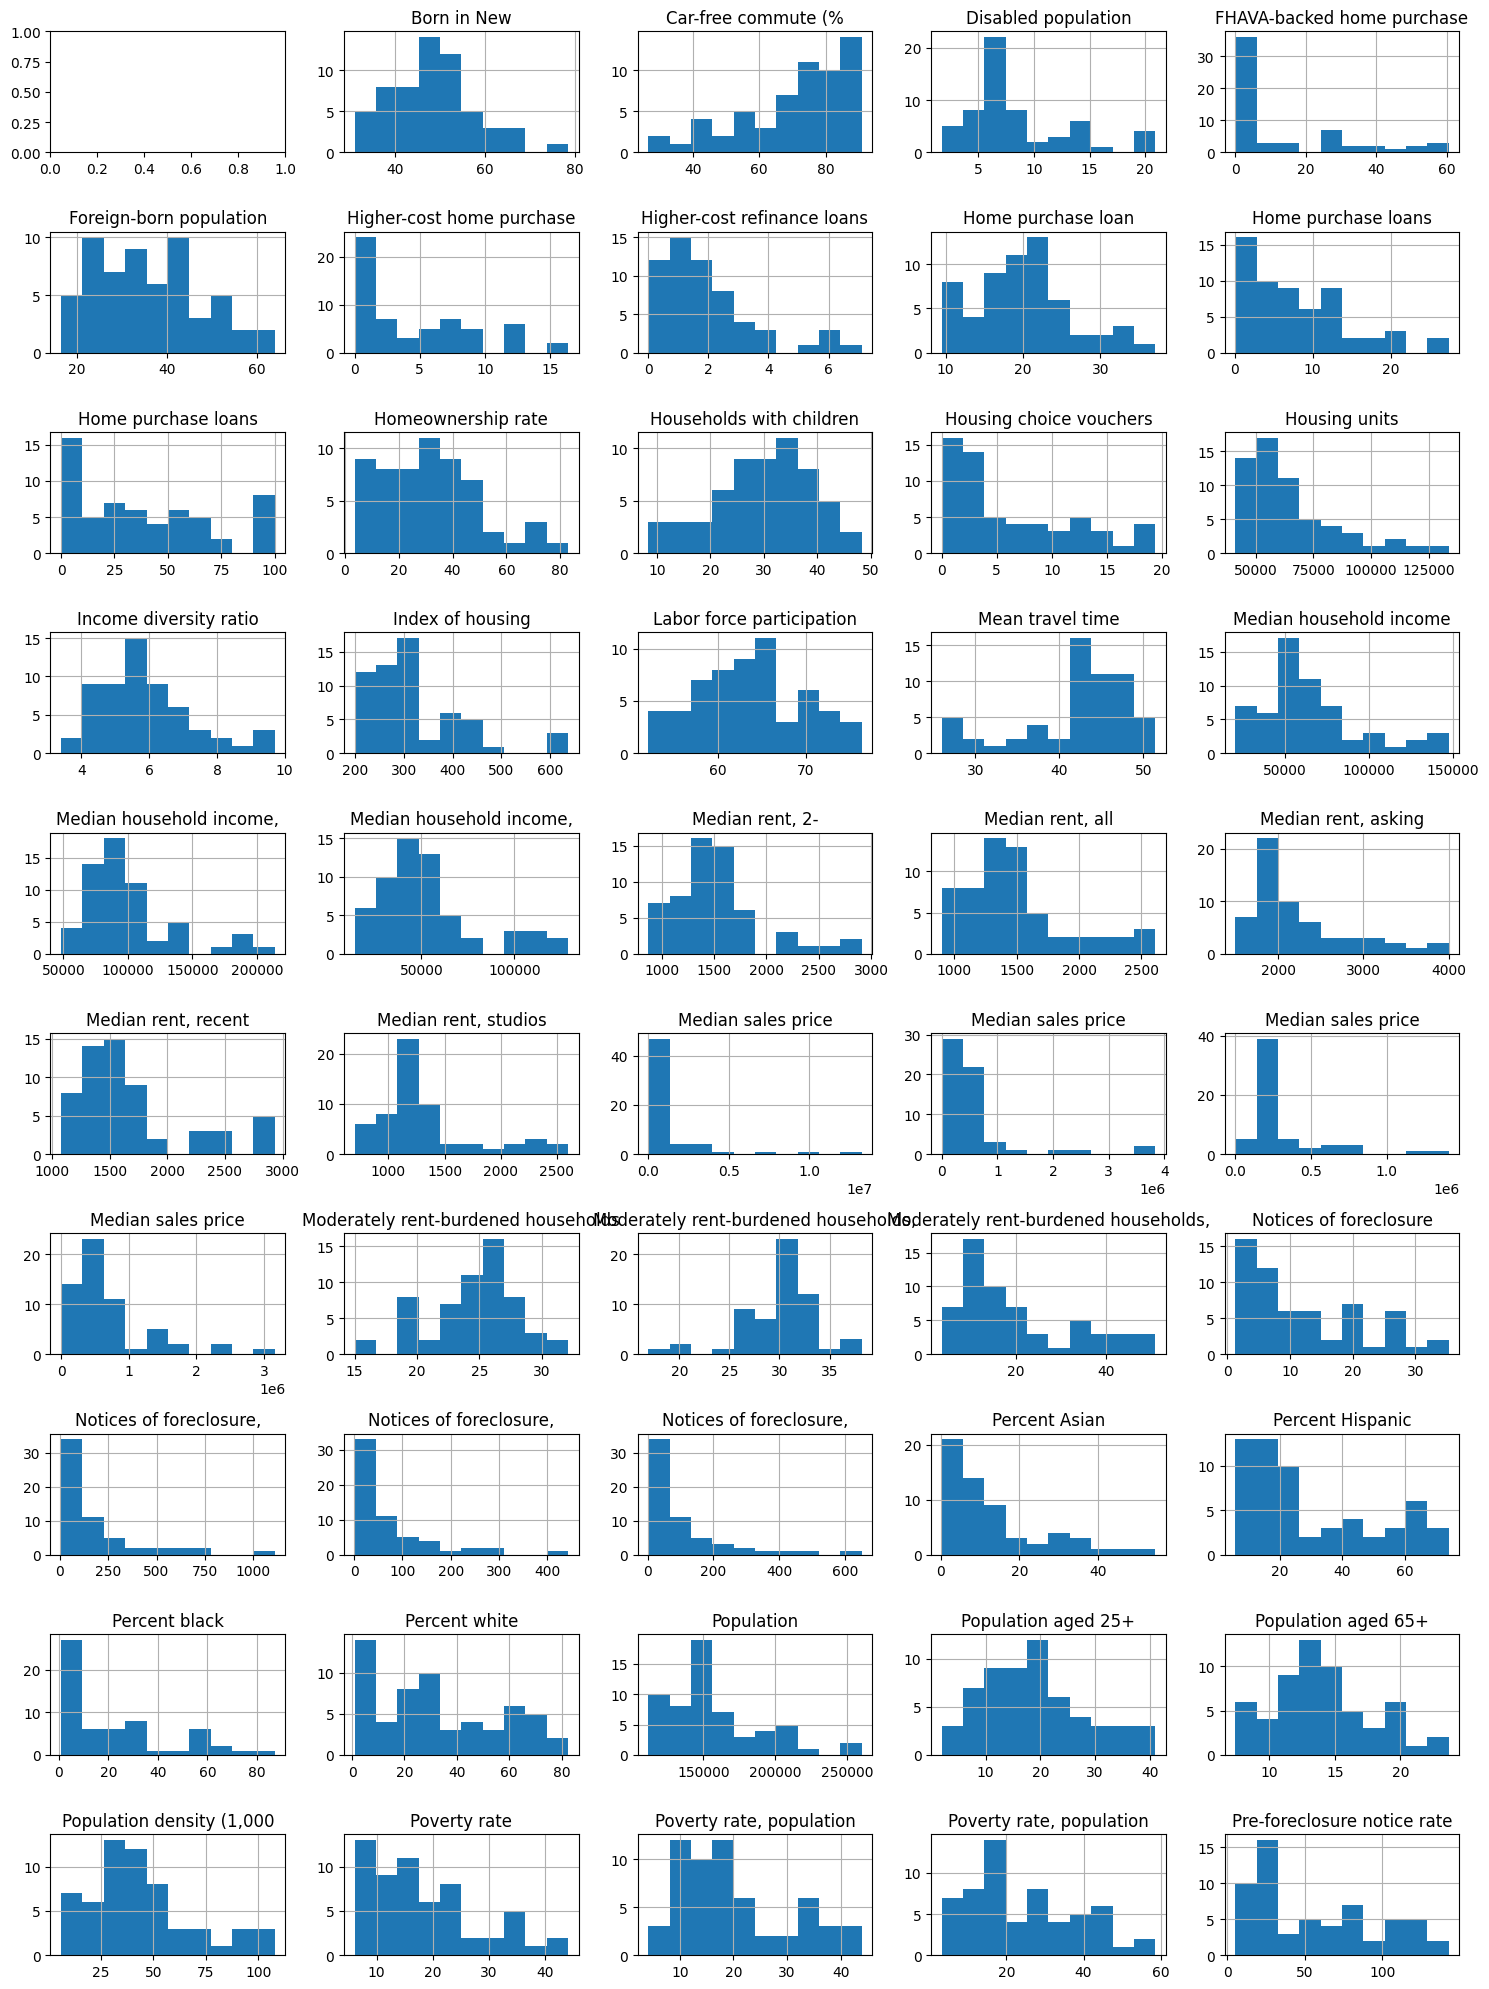

In [14]:
fig, ax = plt.subplots(nrows=10, ncols=5, figsize=(15,20))
ax = ax.flatten()
for i, col in enumerate(columns):
    if df[col].dtype != np.dtype('object'):
        df[col].hist(ax=ax[i])
        ax[i].set_title(' '.join(col.split(' ')[:3]))
plt.tight_layout()

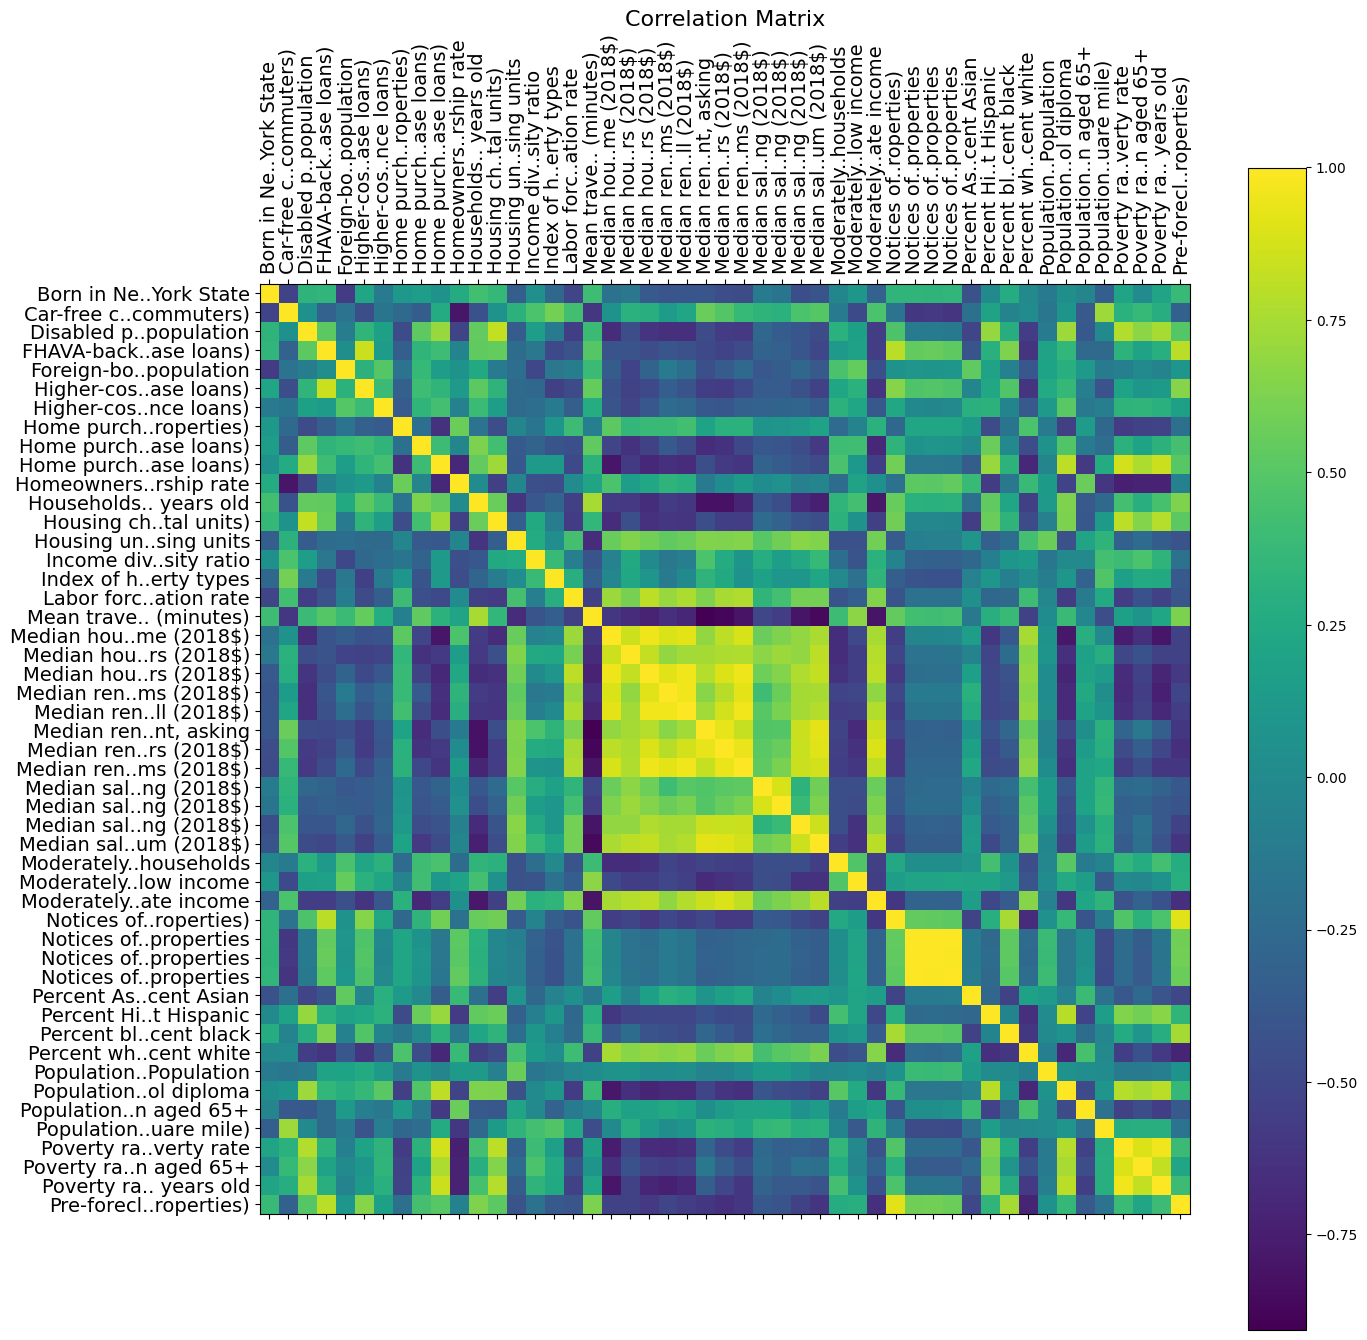

In [15]:
import seaborn as sns
cropped_names = [label[:10]+'..'+label[-10:] for label in df.select_dtypes(['number']).columns]
fig = plt.figure(figsize=(15, 15))
corr_matrix = df[columns[1:]].corr()
plt.matshow(corr_matrix, fignum=fig.number)
plt.xticks(range(df.select_dtypes(['number']).shape[1]), cropped_names, fontsize=14, rotation=90)
plt.yticks(range(df.select_dtypes(['number']).shape[1]), cropped_names, fontsize=14)
plt.colorbar()
plt.title('Correlation Matrix', fontsize=16)
plt.show()


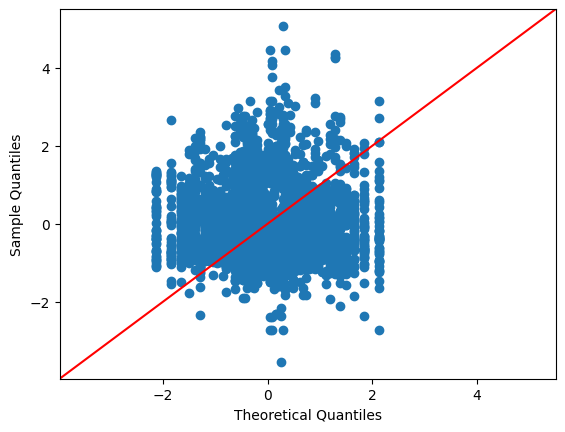

In [16]:
num_df = df[columns[1:]]
fig=sm.qqplot((num_df-num_df.mean())/num_df.std(), line='45')

The points deviate significantly from the straight line in the center, it indicates departures from normality. In general, that means that data isn't normaly distributed.

## Hypotesis testing

The goal get information about data distribution in dataset and perform tests of equivalency of mean metrices of normaly distributed variables.

### Normality of data

First of all, we perform multivariate test of normality of data

In [17]:
# !pip install pingouin
import pingouin as pg

# Built-in function in pingouin
# The Henze-Zirkler's test for multivariate normality

res = pg.multivariate_normality(num_df, alpha=.05)
print(res)

HZResults(hz=1.00104483639522, pval=0.0, normal=False)


Henze-Zirkler's test failed, than numerical data from dataset isn't normaly distributed. Similar result was shown in Q-Q plot.

The next step is check normality of each valiable. We'll use Kolmogorov-Smirnov test.

In [18]:
res_dict = {'Column':[], 'p-value':[]}
for col in columns[1:]:
    norm_col = (num_df[col]-num_df[col].mean())/num_df[col].std()
    res = sts.kstest(norm_col, 'norm')
    res_dict['Column'].append(col)
    res_dict['p-value'].append(res.pvalue)

res_df = pd.DataFrame.from_dict(res_dict)
res_df.sort_values('p-value', ascending=False)

Column   p-value
16                     Labor force participation rate  0.969691
10                                 Homeownership rate  0.776708
30                Moderately rent-burdened households  0.699161
11        Households with children under 18 years old  0.689440
4                             Foreign-born population  0.671487
43                                Population aged 65+  0.612592
0                              Born in New York State  0.596545
40                                      Percent white  0.504369
7      Home purchase loan rate (per 1,000 properties)  0.433483
8   Home purchase loans in LMI tracts (% of home p...  0.353874
9   Home purchase loans to LMI borrowers (% of hom...  0.338341
42  Population aged 25+ without a high school diploma  0.314136
45                                       Poverty rate  0.307983
44  Population density (1,000 persons per square m...  0.305619
14                             Income diversity ratio  0.289094
18                    Median household income (2018$)  0.208773
47        Poverty rate, population under 18 years old  0.197987
31    Moderately rent-burdened households, low income  0.193849
1                   Car-free commute (% of commuters)  0.170578
6   Higher-cost refinance loans (% of refinance lo...  0.138003
46                  Poverty rate, population aged 65+  0.115078
33  Notices of foreclosure rate (per 1,000 1-4 fam...  0.071253
5   Higher-cost home purchase loans (% of home pur...  0.066255
48  Pre-foreclosure notice rate (per 1,000 1-4 fam...  0.065125
32  Moderately rent-burdened households, moderate ...  0.059964
37                                      Percent Asian  0.054372
21             Median rent, 2- and 3-bedrooms (2018$)  0.049729
13                                      Housing units  0.046981
12  Housing choice vouchers (% of occupied, privat...  0.042490
20           Median household income, renters (2018$)  0.035435
19        Median household income, homeowners (2018$)  0.034975
15  Index of housing price appreciation, all prope...  0.034730
41                                         Population  0.034603
39                                      Percent black  0.025574
38                                   Percent Hispanic  0.022434
22                           Median rent, all (2018$)  0.021759
2                                 Disabled population  0.020444
23                                Median rent, asking  0.016244
24                 Median rent, recent movers (2018$)  0.015220
17                 Mean travel time to work (minutes)  0.012773
29   Median sales price per unit, condominium (2018$)  0.009856
34  Notices of foreclosure, all residential proper...  0.004825
35  Notices of foreclosure, initial, 1-4 family an...  0.003669
36  Notices of foreclosure, repeat, 1-4 family and...  0.003374
25        Median rent, studios and 1-bedrooms (2018$)  0.002124
3   FHAVA-backed home purchase loans (% of home pu...  0.000243
28  Median sales price per unit, 5+ family buildin...  0.000042
27  Median sales price per unit, 2-4 family buildi...  0.000010
26  Median sales price per unit, 1 family building...  0.000003

Testing results shown that here we have columns which looks very close to normal distribution. We choosed $\alpha=0.65$ to separate columns.

In [55]:
alpha = .5
norm_cols = res_df[res_df['p-value']>alpha]['Column'].to_list()
res_df[res_df['p-value']>alpha]

Column   p-value
0                        Born in New York State  0.596545
4                       Foreign-born population  0.671487
10                           Homeownership rate  0.776708
11  Households with children under 18 years old  0.689440
16               Labor force participation rate  0.969691
30          Moderately rent-burdened households  0.699161
40                                Percent white  0.504369
43                          Population aged 65+  0.612592

Here is listed normaly distributed columns with their column's index and p-value. The following results shows normaly distributed columns histograms.

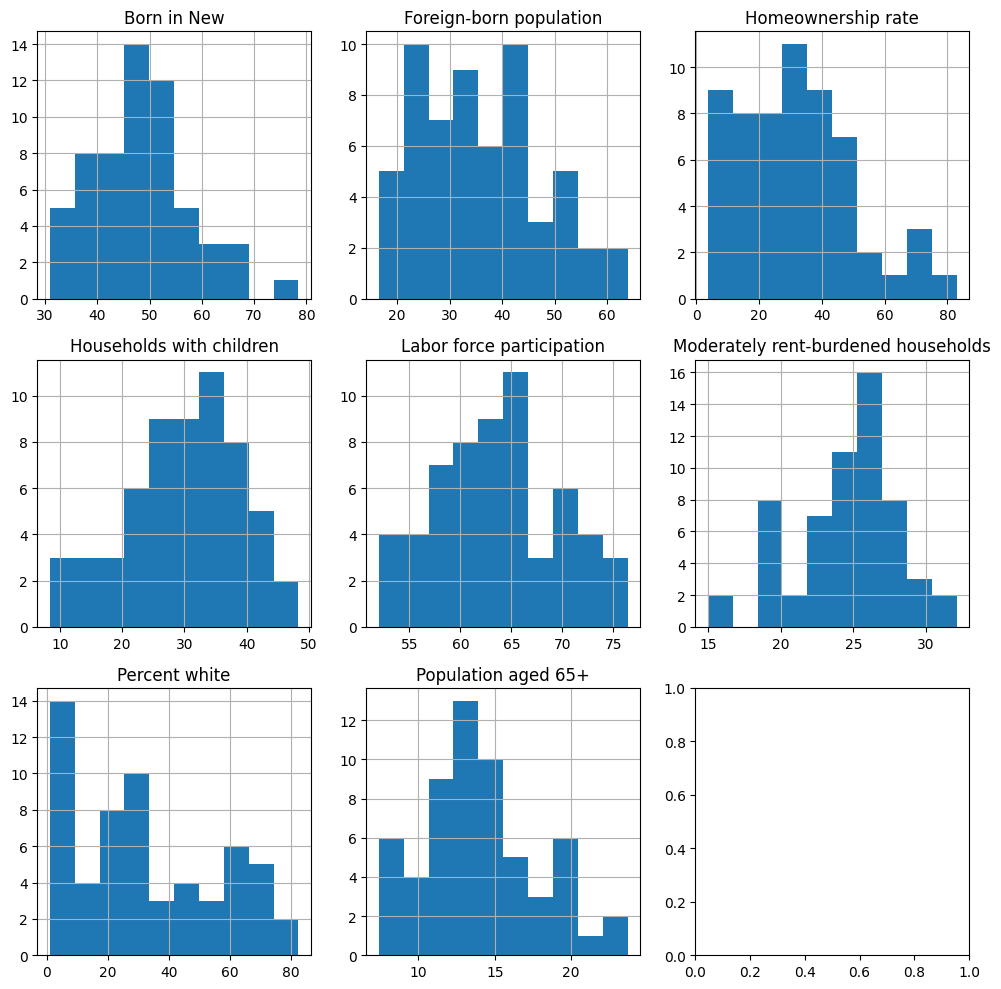

In [57]:
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(10,10))
ax = ax.flatten()
# ax=[ax]
for i, col in enumerate(norm_cols):
    df[col].hist(ax=ax[i])
    ax[i].set_title(' '.join(col.split(' ')[:3]))
plt.tight_layout()

In [58]:
data_normal = df[norm_cols]

### Testing

In this section we shpuld perform test of equality of means matrices.

We'll use ANOVA to test equality of first two columns counterwise to other.

In [59]:
data_normal.describe().T

count       mean        std   
Born in New York State                        59.0  48.388136   9.595924  \
Foreign-born population                       59.0  36.030508  11.864032   
Homeownership rate                            59.0  31.681356  18.922952   
Households with children under 18 years old   59.0  29.718644   9.180855   
Labor force participation rate                59.0  63.694915   6.166300   
Moderately rent-burdened households           59.0  24.633898   3.528828   
Percent white                                 59.0  32.191525  24.068819   
Population aged 65+                           59.0  14.120339   3.772531   

                                              min    25%   50%    75%   max  
Born in New York State                       30.9  41.60  48.1  53.25  78.5  
Foreign-born population                      16.5  25.85  34.0  44.25  63.9  
Homeownership rate                            3.7  16.75  30.7  42.40  82.9  
Households with children under 18 years old   8.4  24.00  30.2  36.45  48.3  
Labor force participation rate               52.0  59.30  64.0  67.85  76.4  
Moderately rent-burdened households          15.0  22.90  25.0  26.70  32.1  
Percent white                                 1.0  10.75  26.7  50.50  82.5  
Population aged 65+                           7.4  11.45  13.5  16.50  23.7

In [60]:
column_1, column_2 = df[norm_cols[0]], df[norm_cols[1]]
other_columns = data_normal[norm_cols[2:]]

res_1={'Columns': norm_cols[2:]}
res_1.update(sts.ttest_ind(column_1, other_columns)._asdict())
print(f'T-test {norm_cols[0]} vs Other'.center(100,'-'))
print(pd.DataFrame.from_dict(res_1).sort_values('pvalue', ascending=False))

print('\n')

res_2={'Columns': norm_cols[2:]}
res_2.update(sts.ttest_ind(column_2, other_columns)._asdict())
print(f'T-test {norm_cols[1]} vs Other'.center(100,'-'))
print(pd.DataFrame.from_dict(res_2).sort_values('pvalue', ascending=False))

print('\n')

res_3 = sts.f_oneway(column_1.to_numpy(), column_2.to_numpy(), *other_columns.to_numpy().T)
print("Results of the one-way ANOVA test".center(100,'-'))
print("F-statistic:", res_3.statistic)
print("p-value:", res_3.pvalue)

-------------------------------T-test Born in New York State vs Other-------------------------------
                                       Columns  statistic        pvalue
4                                Percent white   4.801343  4.744932e-06
0                           Homeownership rate   6.048329  1.833293e-08
2               Labor force participation rate -10.307725  4.435399e-18
1  Households with children under 18 years old  10.798075  3.093963e-19
3          Moderately rent-burdened households  17.845862  4.693611e-35
5                          Population aged 65+  25.528040  2.003448e-49


------------------------------T-test Foreign-born population vs Other-------------------------------
                                       Columns  statistic        pvalue
4                                Percent white   1.098897  2.740887e-01
0                           Homeownership rate   1.495729  1.374400e-01
1  Households with children under 18 years old   3.231845  1.601229e-03
3   

## Method of Principal Components

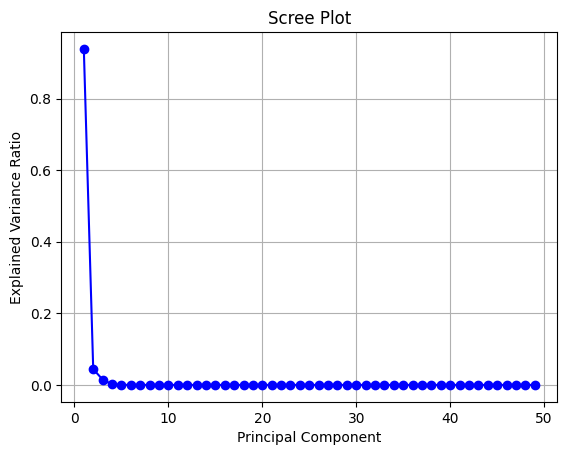

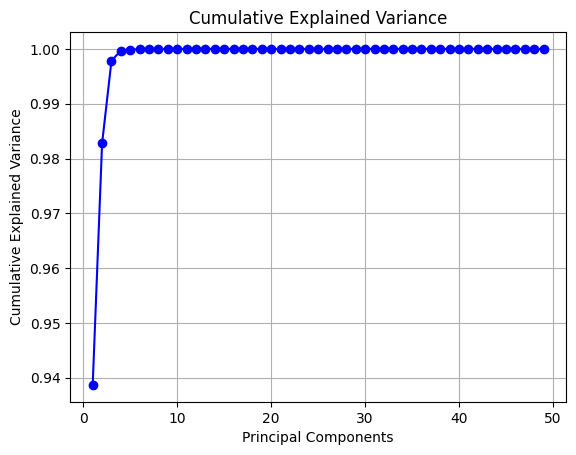

In [24]:
from sklearn.decomposition import PCA

pca = PCA()
pca.fit(num_df)

explained_variance_ratio = pca.explained_variance_ratio_

# Scree plot
plt.plot(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, 'bo-')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('Scree Plot')
plt.grid(True)
plt.show()

# Cumulative explained variance plot
cumulative_explained_variance = np.cumsum(explained_variance_ratio)
plt.plot(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance, 'bo-')
plt.xlabel('Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance')
plt.grid(True)
plt.show()

Appropriate number of components should explain above 80-90% of the total variance

In [25]:
variance_threshold = 0.8
n_components = np.argmax(cumulative_explained_variance >= variance_threshold) + 1
print(f'n_components for {variance_threshold*100}% threshold:', n_components)

n_components for 80.0% threshold: 1


In [26]:
pca = PCA(2)
pca.fit(num_df)

pca.explained_variance_ratio_

array([0.93869224, 0.04408674])

Text(0.5, 1.0, 'Transformed data')

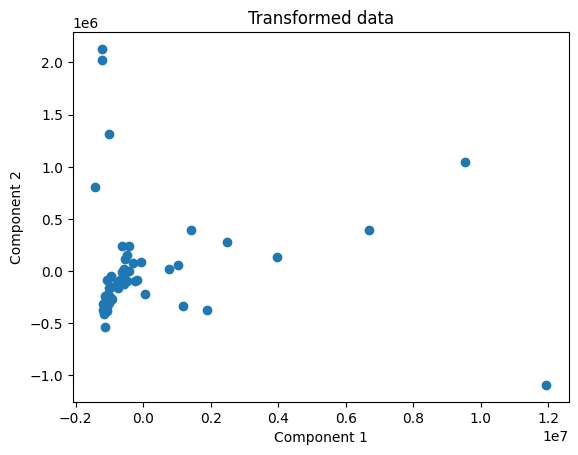

In [27]:
new_data = pca.transform(num_df)
plt.scatter(new_data[:,0], new_data[:,1])
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.title('Transformed data')

## Classification

### Normal data

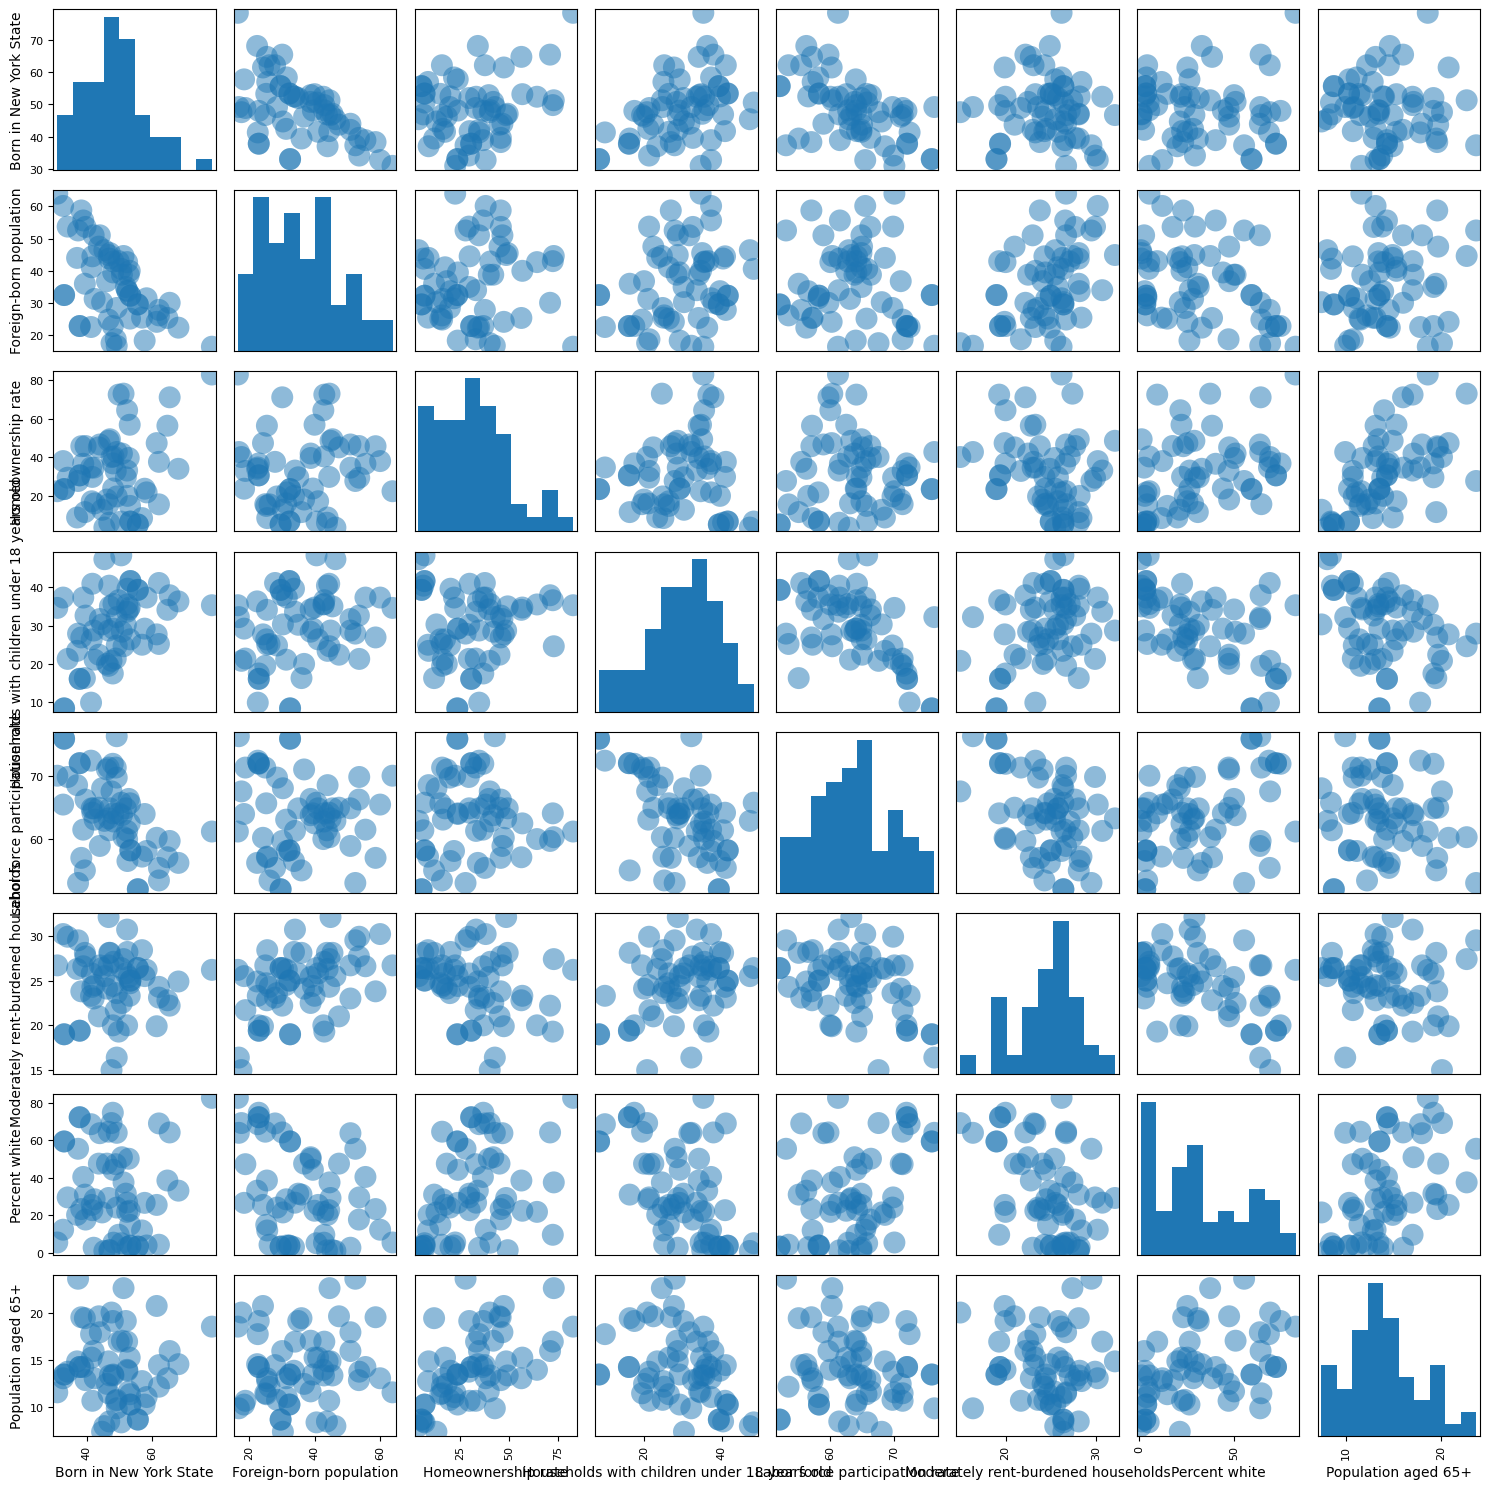

In [61]:
pd.plotting.scatter_matrix(data_normal, figsize=(15, 15), s=1e3)
plt.tight_layout()

In [29]:
# For truly random selection:
# random_features = np.random.choice(norm_cols, size=2)
# while random_features[0]==random_features[1]:
#     random_features = np.random.choice(norm_cols, size=2)

# But more appropriate choice is
random_features = ['Foreign-born population', 'Homeownership rate']
print('Selected features:', random_features)

Selected features: ['Foreign-born population', 'Homeownership rate']


In [30]:
# Prepare data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(data_normal[random_features])
scaled_data = scaler.transform(data_normal[random_features].copy())

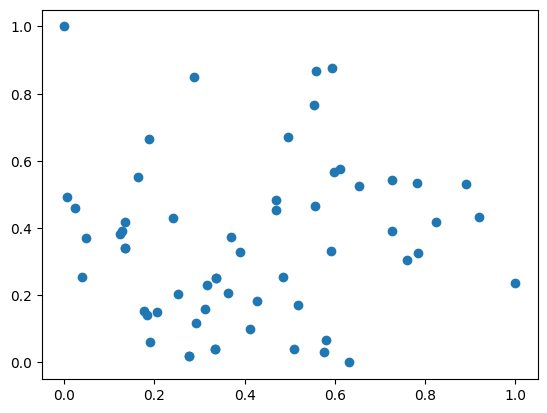

In [31]:
plt.scatter(scaled_data[:,0], scaled_data[:,1])

D:\conda\envs\tf_gpu2\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
D:\conda\envs\tf_gpu2\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
D:\conda\envs\tf_gpu2\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
D:\conda\envs\tf_gpu2\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable 

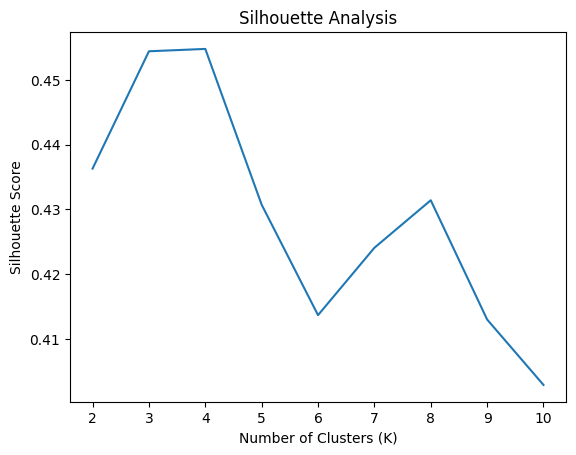

In [32]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

_min_clusters, _max_clusters = 2,11
silhouette_scores = []
for k in range(_min_clusters, _max_clusters):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(scaled_data)
    score = silhouette_score(scaled_data, kmeans.labels_)
    silhouette_scores.append(score)
plt.plot(range(_min_clusters, _max_clusters), silhouette_scores)
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Analysis')
plt.show()

n_clusters = int(np.arange(_min_clusters, _max_clusters)[np.where(silhouette_scores==max(silhouette_scores))][0])

The silhouette score measures how well each data point fits its assigned cluster compared to other clusters. A higher score indicates better clustering. By ```silhouette_scores``` the best number of clusters is 4, which is more that alowed by task condition. The next cluster selection performed with ```n_clusters = 3```, which has the silhouette score close to best. 

In [33]:
n_clusters = 3
kmeans = KMeans(n_clusters=n_clusters)
kmeans.fit(scaled_data)

D:\conda\envs\tf_gpu2\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
D:\conda\envs\tf_gpu2\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


KMeans(n_clusters=3)

<Axes: xlabel='Foreign-born population', ylabel='Homeownership rate'>

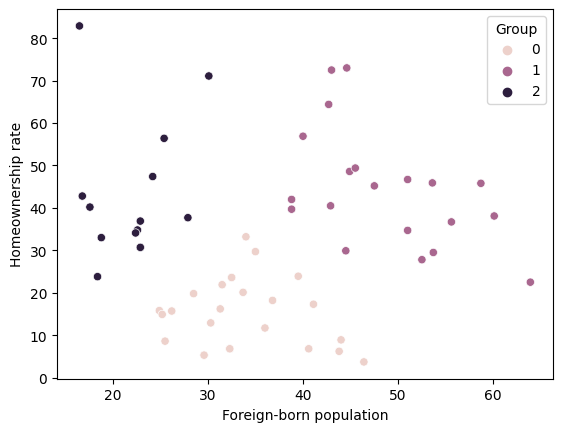

In [34]:
data_normal_clustered = data_normal[random_features].copy()
data_normal_clustered['Group'] = kmeans.labels_
#visualization
sns.scatterplot(data=data_normal_clustered, x=random_features[0], y=random_features[1], hue='Group')

In [35]:
for i in range(n_clusters):
    print(f'Cluster {i}'.center(50,'-'))
    print(df['Neighborhood'].loc[data_normal_clustered.Group == i])

--------------------Cluster 0---------------------
0                  Greenpoint/Williamsburg
3                                 Bushwick
4              East New York/Starrett City
7           Crown Heights/Prospect Heights
8     South Crown Heights/Lefferts Gardens
13                        Flatbush/Midwood
15                             Brownsville
18                      Mott Haven/Melrose
19                    Hunts Point/Longwood
20                      Morrisania/Crotona
21                    Highbridge/Concourse
22              Fordham/University Heights
23                    Belmont/East Tremont
24             Kingsbridge Heights/Bedford
25                     Riverdale/Fieldston
26                   Parkchester/Soundview
28                   Morris Park/Bronxdale
32               Lower East Side/Chinatown
33                         Clinton/Chelsea
34                                 Midtown
38            Morningside Heights/Hamilton
39                          Central Harlem
40 

In [36]:
from sklearn.model_selection import train_test_split

# Spliting data with using 'stratify' to get same distributions of class labels for each dataset
data_da, data_bayes, cities_da, cities_bayes = train_test_split(data_normal_clustered[random_features], data_normal_clustered['Group'], test_size=0.3, stratify=data_normal_clustered['Group'], random_state=42)

print( data_da.shape, data_bayes.shape)

(41, 2) (18, 2)


In [86]:
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report

lda = LinearDiscriminantAnalysis()

scores = cross_val_score(lda, data_da, cities_da, cv=5)

print("Cross-validation scores:", scores)
print("Mean cross-validation score:", scores.mean())

lda.fit(data_da, cities_da)
da_pred = lda.predict(data_da)
print('Classification results for DA'.center(70, '-'))
print(classification_report(cities_da, da_pred))

Cross-validation scores: [1.    0.875 1.    1.    1.   ]
Mean cross-validation score: 0.975
--------------------Classification results for DA---------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        17
           1       1.00      1.00      1.00        14
           2       1.00      1.00      1.00        10

    accuracy                           1.00        41
   macro avg       1.00      1.00      1.00        41
weighted avg       1.00      1.00      1.00        41



Text(0.5, 1.0, 'Visualization of Classification results')

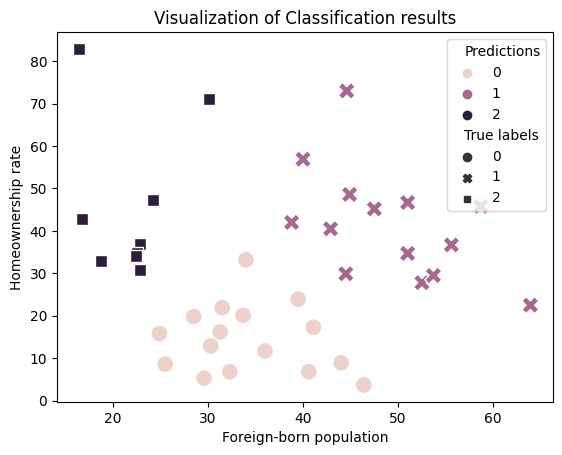

In [89]:
data_da['Predictions'] = da_pred
data_da['True labels'] = data_normal_clustered['Group']
sns.scatterplot(data=data_da, x=random_features[0], y=random_features[1], hue='Predictions', style='True labels', s=150)
plt.title('Visualization of Classification results')

In [38]:
from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB()

scores = cross_val_score(gnb, data_bayes, cities_bayes, cv=4)

print("Cross-validation scores:", scores)
print("Mean cross-validation score:", scores.mean())

gnb.fit(data_bayes, cities_bayes)
gnb_pred = gnb.predict(data_bayes)
print('Classification results for DA'.center(70, '-'))
print(classification_report(cities_bayes, gnb_pred))

Cross-validation scores: [1.   0.8  0.75 0.75]
Mean cross-validation score: 0.825
--------------------Classification results for DA---------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         8
           1       1.00      1.00      1.00         6
           2       1.00      1.00      1.00         4

    accuracy                           1.00        18
   macro avg       1.00      1.00      1.00        18
weighted avg       1.00      1.00      1.00        18



In [39]:
from sklearn.neighbors import KernelDensity
import numpy as np

# Note:
# data_da - train data
# data_bayes - test data
# for KDE estimation

kde_models = {}
for class_label in range(3):
    class_data = data_da[cities_da == class_label]
    kde = KernelDensity()
    kde.fit(class_data)
    kde_models[class_label] = kde

class_priors = {}
for class_label in range(3):
    class_priors[class_label] = len(cities_da[cities_da == class_label]) / len(cities_da)

class_conditional_probs = {}
for class_label, kde in kde_models.items():
    log_probs = kde.score_samples(data_bayes)
    class_conditional_probs[class_label] = np.exp(log_probs)

kde_pred = []
for i in range(len(data_bayes)):
    posterior_probs = []
    for class_label in range(3):
        posterior_prob = class_conditional_probs[class_label][i] * class_priors[class_label]
        posterior_probs.append(posterior_prob)
    predicted_class = cities_da.unique()[np.argmax(posterior_probs)]
    kde_pred.append(predicted_class)

In [40]:
kde_pred, cities_bayes.to_list()

([1, 0, 1, 1, 1, 1, 0, 2, 0, 0, 2, 2, 1, 0, 2, 1, 0, 1],
 [0, 1, 0, 0, 0, 0, 1, 2, 1, 1, 2, 2, 0, 1, 2, 0, 1, 0])

In [92]:
# Renaming of classes for classification report
kde_pred_renamed = np.array(kde_pred.copy())
_cls_ind = [np.array(kde_pred)==i for i in range(3)]
print(_cls_ind[0])
kde_pred_renamed[_cls_ind[0]]=1
kde_pred_renamed[_cls_ind[1]]=0
kde_pred_renamed[_cls_ind[2]]=2

kde_pred_renamed.tolist(), cities_bayes.to_list()

[False  True False False False False  True False  True  True False False
 False  True False False  True False]


([0, 1, 0, 0, 0, 0, 1, 2, 1, 1, 2, 2, 0, 1, 2, 0, 1, 0],
 [0, 1, 0, 0, 0, 0, 1, 2, 1, 1, 2, 2, 0, 1, 2, 0, 1, 0])

In [93]:
print('Classification results for data_bayes with KDE'.center(70,'-'))
print(classification_report(kde_pred_renamed, cities_bayes))

------------Classification results for data_bayes with KDE------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         8
           1       1.00      1.00      1.00         6
           2       1.00      1.00      1.00         4

    accuracy                           1.00        18
   macro avg       1.00      1.00      1.00        18
weighted avg       1.00      1.00      1.00        18



Text(0.5, 1.0, 'Visualization of classification results (KDE)')

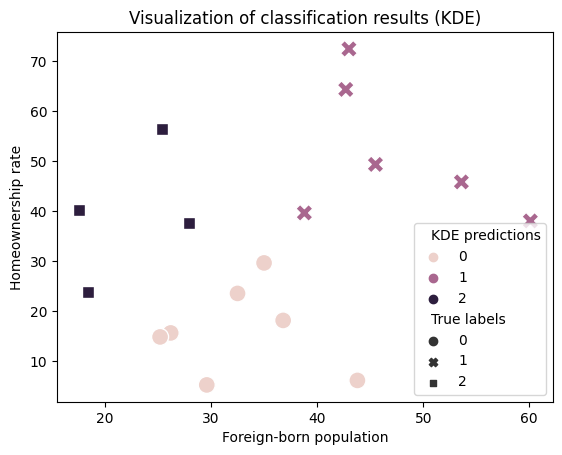

In [94]:
data_bayes['KDE predictions'] = kde_pred_renamed.tolist()
data_bayes['True labels'] = cities_bayes.to_list()
sns.scatterplot(data=data_bayes, x=random_features[0], y=random_features[1], hue='KDE predictions', style='True labels', s=150)
plt.title('Visualization of classification results (KDE)')

### Nonnormal data

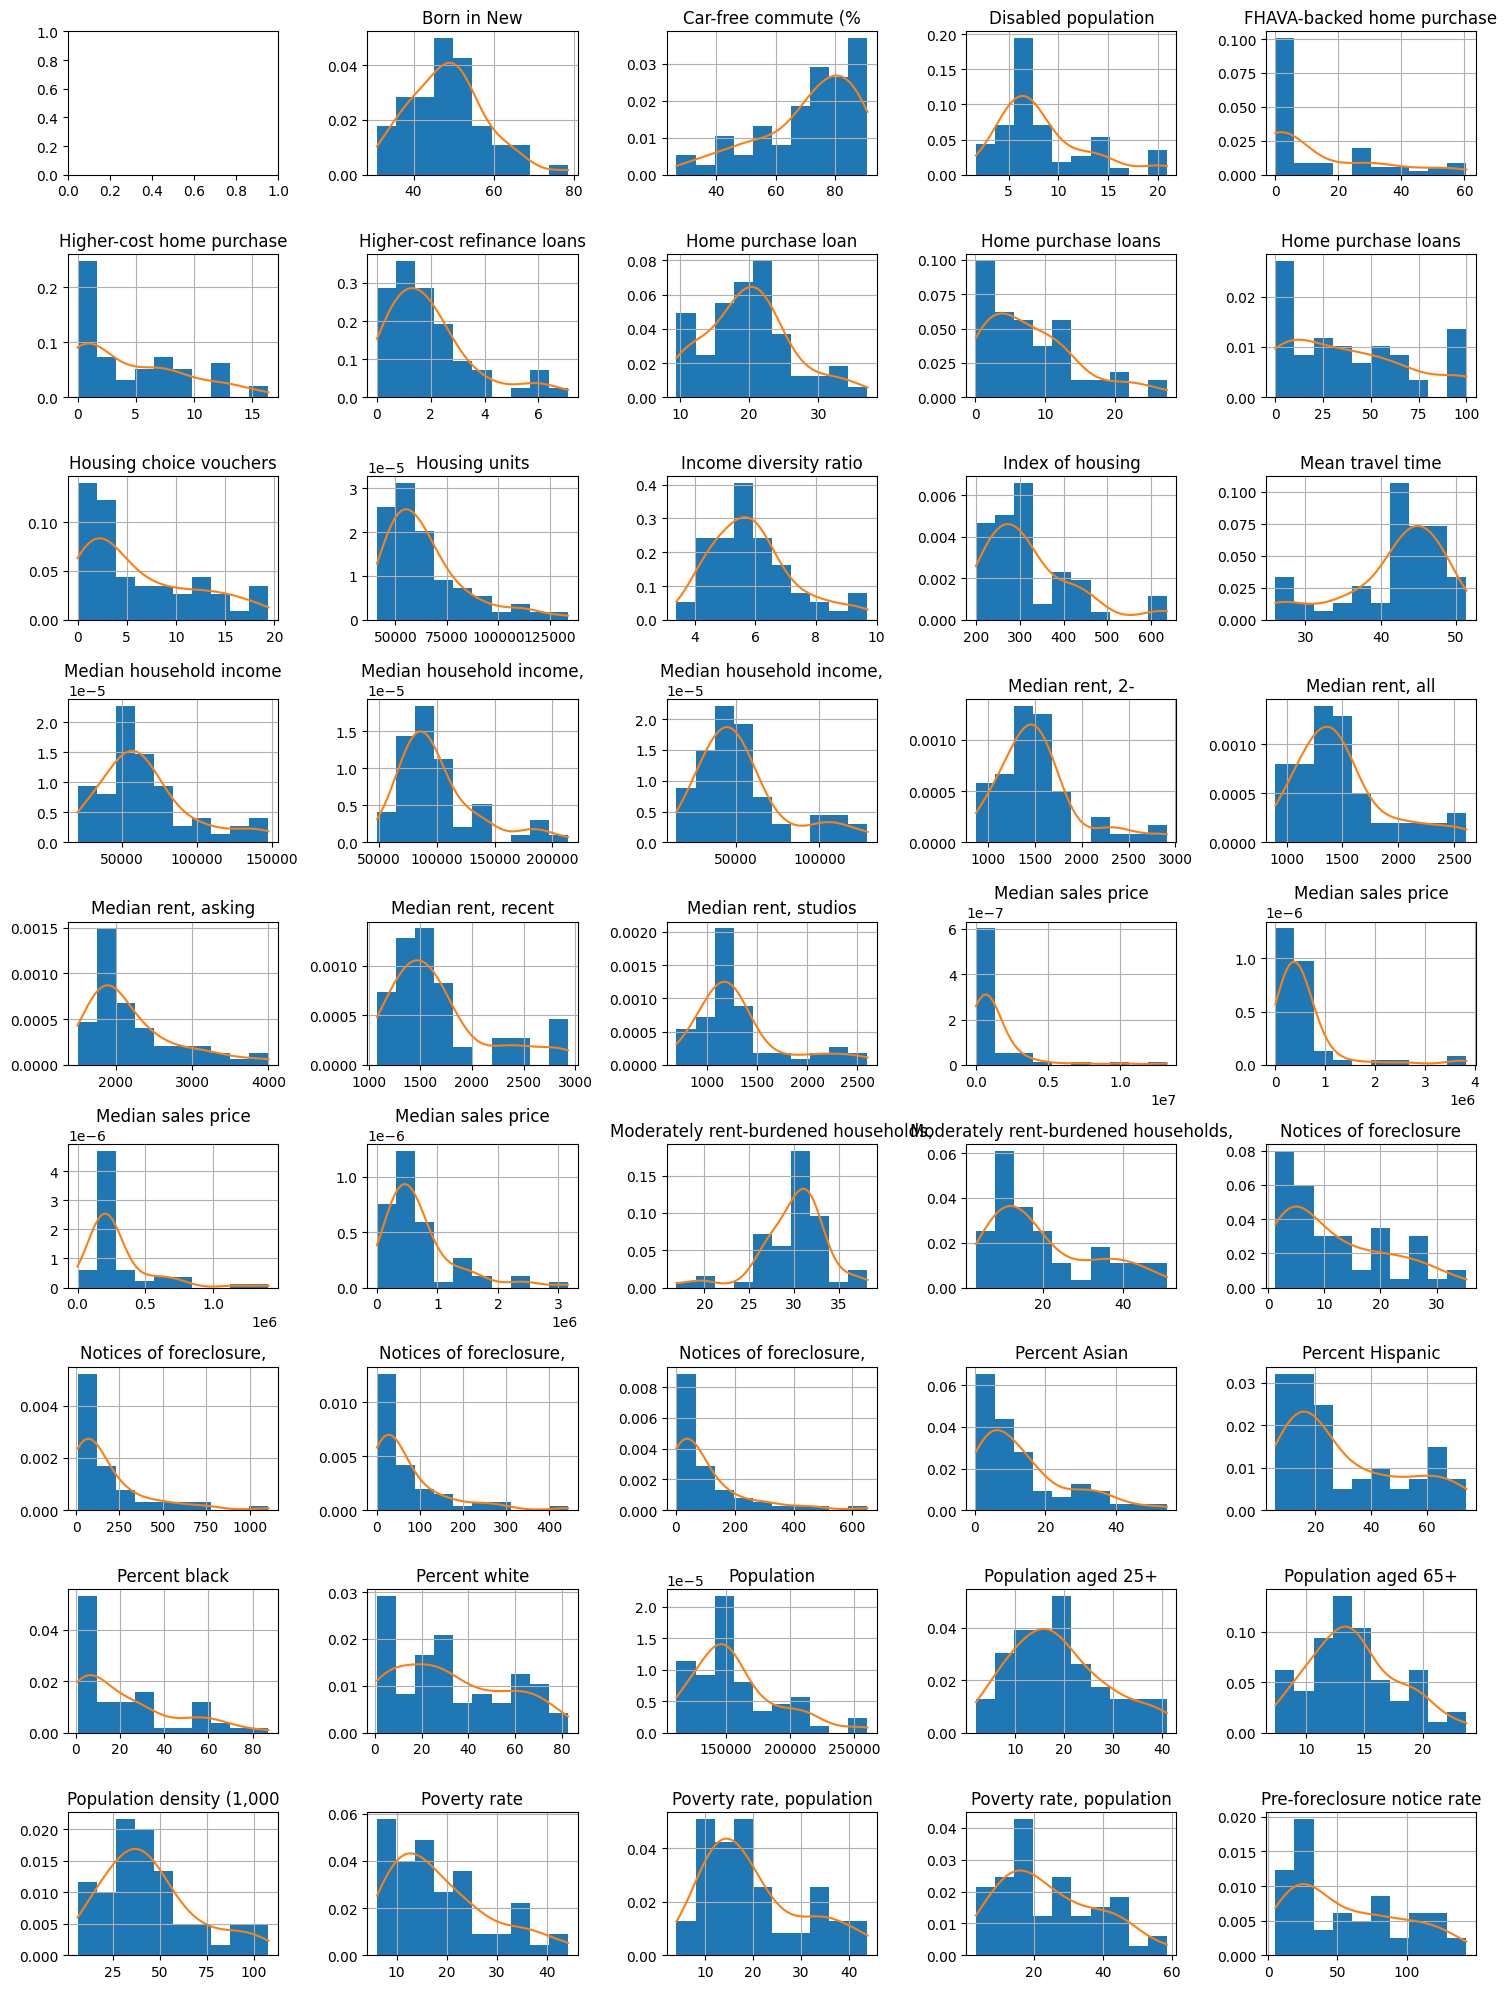

In [44]:
data_nonnormal = df.drop(columns=norm_cols)
fig, ax = plt.subplots(nrows=9, ncols=5, figsize=(15,20))
ax = ax.flatten()
kdes = dict()
for i, col in enumerate(data_nonnormal.columns.to_list()):
    if data_nonnormal[col].dtype != np.dtype('object'):
        kde = sts.gaussian_kde(data_nonnormal[col])
        x = np.linspace(data_nonnormal[col].min(), data_nonnormal[col].max(), 56)
        kde_values = kde(x)
        kdes[col]=kde_values
        data_nonnormal[col].hist(ax=ax[i], density=True)
        ax[i].plot(x, kde_values)
        ax[i].set_title(' '.join(col.split(' ')[:3]))
plt.tight_layout()

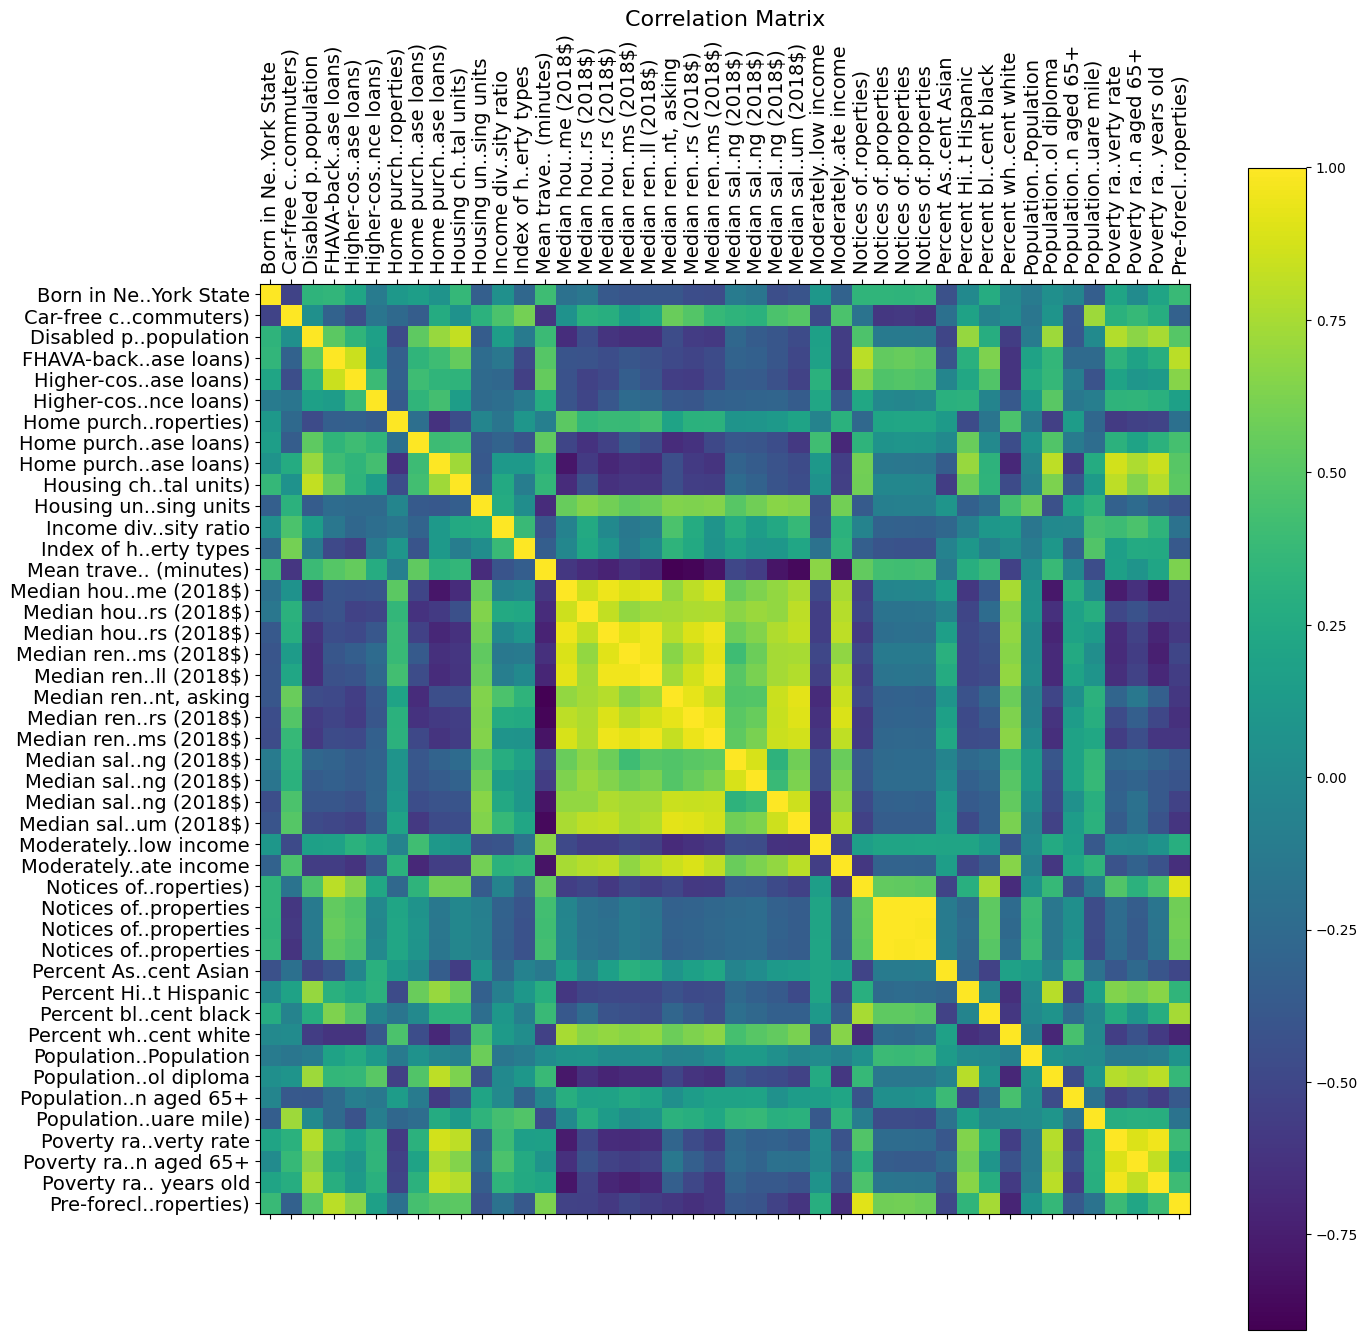

In [45]:
cropped_names = [label[:10]+'..'+label[-10:] for label in data_nonnormal.select_dtypes(['number']).columns]
fig = plt.figure(figsize=(15, 15))
corr_matrix = data_nonnormal[data_nonnormal.columns[1:]].corr()
plt.matshow(corr_matrix, fignum=fig.number)
plt.xticks(range(data_nonnormal.select_dtypes(['number']).shape[1]), cropped_names, fontsize=14, rotation=90)
plt.yticks(range(data_nonnormal.select_dtypes(['number']).shape[1]), cropped_names, fontsize=14)
plt.colorbar()
plt.title('Correlation Matrix', fontsize=16)
plt.show()

In [46]:
print(*data_nonnormal.columns.to_list(), sep='\n')

Neighborhood
Born in New York State
Car-free commute (% of commuters)
Disabled population
FHAVA-backed home purchase loans (% of home purchase loans)
Higher-cost home purchase loans (% of home purchase loans)
Higher-cost refinance loans (% of refinance loans)
Home purchase loan rate (per 1,000 properties)
Home purchase loans in LMI tracts (% of home purchase loans)
Home purchase loans to LMI borrowers (% of home purchase loans)
Housing choice vouchers (% of occupied, privately owned rental units)
Housing units
Income diversity ratio
Index of housing price appreciation, all property types
Mean travel time to work (minutes)
Median household income (2018$)
Median household income, homeowners (2018$)
Median household income, renters (2018$)
Median rent, 2- and 3-bedrooms (2018$)
Median rent, all (2018$)
Median rent, asking
Median rent, recent movers (2018$)
Median rent, studios and 1-bedrooms (2018$)
Median sales price per unit, 1 family building (2018$)
Median sales price per unit, 2-4 fa

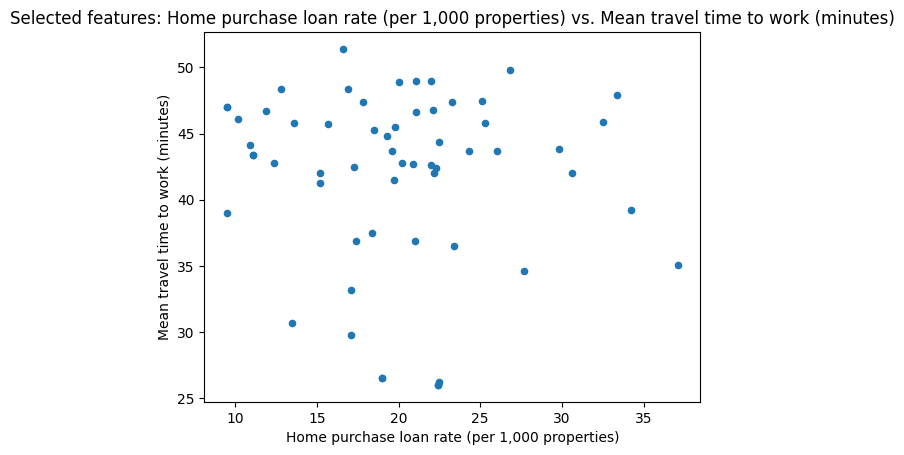

In [47]:
# We selected features according to correlation matrix

# selected_features = ['Disabled population', 'Car-free commute (% of commuters)']
# data_nonnormal[selected_features].plot.scatter(x=selected_features[0], y=selected_features[1])
# plt.title(f'Selected features: {" vs. ".join(selected_features)}')
# plt.show()

selected_features = ['Home purchase loan rate (per 1,000 properties)', 'Mean travel time to work (minutes)']
data_nonnormal[selected_features].plot.scatter(x=selected_features[0], y=selected_features[1])
plt.title(f'Selected features: {" vs. ".join(selected_features)}')
plt.show()

D:\conda\envs\tf_gpu2\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
D:\conda\envs\tf_gpu2\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
D:\conda\envs\tf_gpu2\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
D:\conda\envs\tf_gpu2\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable 

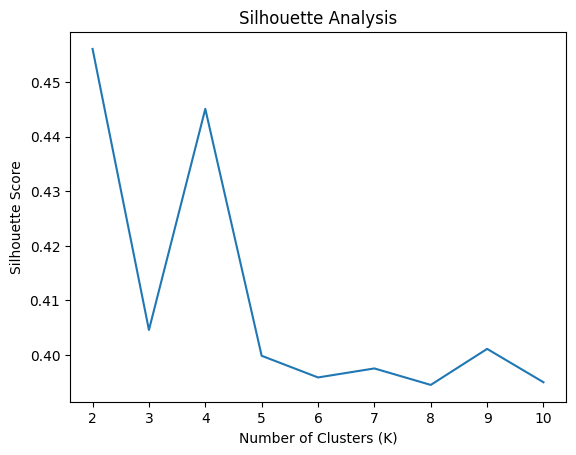

In [48]:
# K-Means clustering of non-normal data

scaler2 = MinMaxScaler()
scaler2.fit(data_nonnormal[selected_features])
scaled_data_nonnormal = scaler2.transform(data_nonnormal[selected_features].copy())

# Selecting number of clusters

_min_clusters, _max_clusters = 2,11
silhouette_scores = []
for k in range(_min_clusters, _max_clusters):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(scaled_data_nonnormal)
    score = silhouette_score(scaled_data_nonnormal, kmeans.labels_)
    silhouette_scores.append(score)
plt.plot(range(_min_clusters, _max_clusters), silhouette_scores)
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Analysis')
plt.show()

n_clusters = int(np.arange(_min_clusters, _max_clusters)[np.where(silhouette_scores==max(silhouette_scores))][0])

```n_clusters = 2```

In [49]:
n_clusters = 2
kmeans2 = KMeans(n_clusters=n_clusters)
kmeans2.fit(scaled_data_nonnormal)

D:\conda\envs\tf_gpu2\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
D:\conda\envs\tf_gpu2\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


KMeans(n_clusters=2)

<Axes: xlabel='Home purchase loan rate (per 1,000 properties)', ylabel='Mean travel time to work (minutes)'>

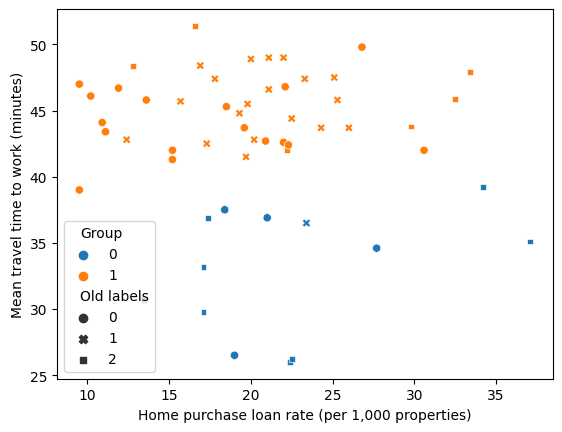

In [50]:
data_nonnormal_clustered = data_nonnormal[selected_features].copy()
data_nonnormal_clustered['Group'] = kmeans2.labels_
data_nonnormal_clustered['Old labels'] = data_normal_clustered['Group']

#visualization
sns.scatterplot(data=data_nonnormal_clustered, x=selected_features[0], y=selected_features[1], hue='Group', style='Old labels')

From plot we can conclude that there is no connection between previous classes and current separation.

In [62]:
data_da2, data_bayes2 = train_test_split(data_nonnormal_clustered, test_size = 0.3, stratify=data_nonnormal_clustered['Group'], random_state=42)

Cross-validation scores: [1.    1.    1.    0.875 0.875]
Mean cross-validation score: 0.95
--------------------Classification results for DA---------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      1.00      1.00        31

    accuracy                           1.00        41
   macro avg       1.00      1.00      1.00        41
weighted avg       1.00      1.00      1.00        41



Text(0.5, 1.0, 'Visualization of Classification results')

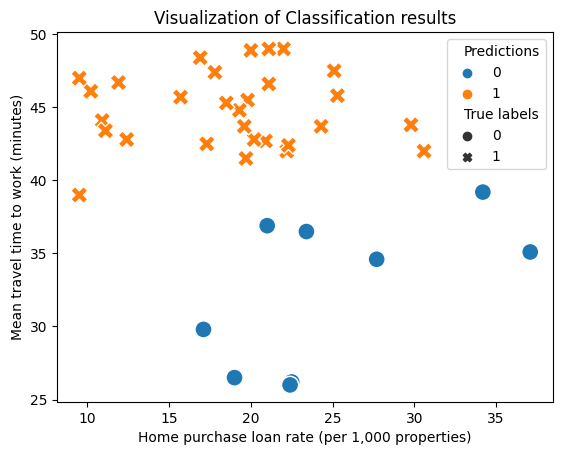

In [63]:
# Discriminant analysis for nonnormal data

lda2 = LinearDiscriminantAnalysis()

scores = cross_val_score(lda, data_da2[selected_features], data_da2['Group'], cv=5)

print("Cross-validation scores:", scores)
print("Mean cross-validation score:", scores.mean())

lda2.fit(data_da2[selected_features], data_da2['Group'])
da_pred = lda2.predict(data_da2[selected_features])
print('Classification results for DA'.center(70, '-'))
print(classification_report(data_da2['Group'], da_pred))

data_da2['Predictions'] = da_pred
data_da2['True labels'] = data_da2['Group']
sns.scatterplot(data=data_da2, x=selected_features[0], y=selected_features[1], hue='Predictions', style='True labels', s=150)
plt.title('Visualization of Classification results')

Cross-validation scores: [0.8 0.8 1.  1. ]
Mean cross-validation score: 0.9
----------------Classification results for Naive Bayes----------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00        13

    accuracy                           1.00        18
   macro avg       1.00      1.00      1.00        18
weighted avg       1.00      1.00      1.00        18



Text(0.5, 1.0, 'Visualization of Classification results')

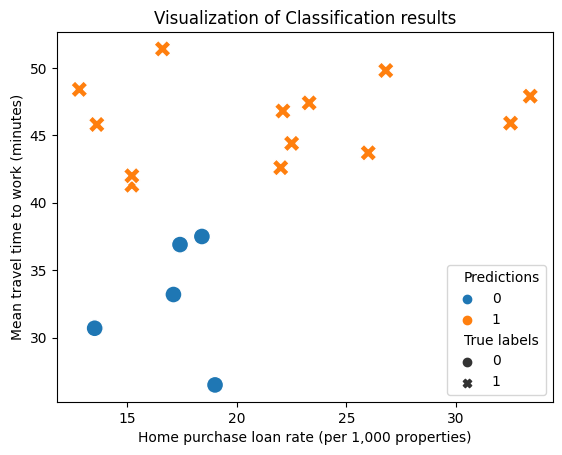

In [64]:
# Discriminant analysis for nonnormal data

gnb2 = GaussianNB()

scores = cross_val_score(gnb2, data_bayes2[selected_features], data_bayes2['Group'], cv=4)

print("Cross-validation scores:", scores)
print("Mean cross-validation score:", scores.mean())

gnb2.fit(data_bayes2[selected_features], data_bayes2['Group'])
bayes_pred = gnb2.predict(data_bayes2[selected_features])
print('Classification results for Naive Bayes'.center(70, '-'))
print(classification_report(data_bayes2['Group'], bayes_pred))

data_bayes2['Predictions'] = bayes_pred
data_bayes2['True labels'] = data_bayes2['Group']
sns.scatterplot(data=data_bayes2, x=selected_features[0], y=selected_features[1], hue='Predictions', style='True labels', s=150)
plt.title('Visualization of Classification results')

--------------------Classification results for KDE--------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00        13

    accuracy                           1.00        18
   macro avg       1.00      1.00      1.00        18
weighted avg       1.00      1.00      1.00        18



Text(0.5, 1.0, 'Visualization of Classification results')

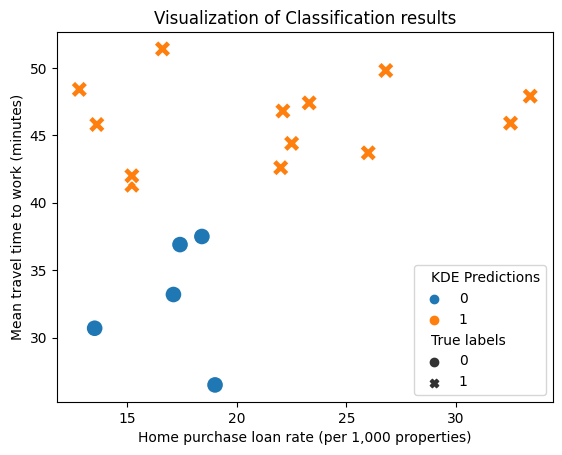

In [65]:
kde_models2 = {}
for class_label in range(2):
    class_data = data_da2[data_da2['Group'] == class_label][selected_features]
    kde = KernelDensity()
    kde.fit(class_data)
    kde_models2[class_label] = kde

class_priors2 = {}
for class_label in range(2):
    class_priors2[class_label] = len(data_da2['Group'][data_da2['Group'] == class_label]) / len(data_da2['Group'])

class_conditional_probs2 = {}
for class_label, kde in kde_models2.items():
    log_probs = kde.score_samples(data_bayes2[selected_features])
    class_conditional_probs2[class_label] = np.exp(log_probs)

kde_pred2 = []
for i in range(len(data_bayes2)):
    posterior_probs = []
    for class_label in range(2):
        posterior_prob = class_conditional_probs2[class_label][i] * class_priors2[class_label]
        posterior_probs.append(posterior_prob)
    predicted_class = list(range(2))[np.argmax(posterior_probs)]
    kde_pred2.append(predicted_class)
    
print('Classification results for KDE'.center(70, '-'))
print(classification_report(data_bayes2['Group'], kde_pred2))

data_bayes2['KDE Predictions'] = kde_pred2
sns.scatterplot(data=data_bayes2, x=selected_features[0], y=selected_features[1], hue='KDE Predictions', style='True labels', s=150)
plt.title('Visualization of Classification results')

## Clustering

[Clustering methods of Sklearn](https://scikit-learn.org/stable/modules/clustering.html):

| Method name               | Parameters                               | Scalability                            | Usecase                                                   | Geometry (metric used)       |
|---------------------------|------------------------------------------|----------------------------------------|-----------------------------------------------------------|------------------------------|
| K-Means                   | number of clusters                        | Very large n_samples, medium n_clusters with MiniBatch code | General-purpose, even cluster size, flat geometry, not too many clusters, inductive | Distances between points      |
| Affinity propagation      | damping, sample preference                | Not scalable with n_samples            | Many clusters, uneven cluster size, non-flat geometry, inductive | Graph distance               |
| Mean-shift                | bandwidth                                | Not scalable with n_samples            | Many clusters, uneven cluster size, non-flat geometry, inductive | Distances between points      |
| Spectral clustering       | number of clusters                        | Medium n_samples, small n_clusters     | Few clusters, even cluster size, non-flat geometry, transductive | Graph distance               |
| Ward hierarchical clustering | number of clusters or distance threshold | Large n_samples and n_clusters         | Many clusters, possibly connectivity constraints, transductive | Distances between points      |
| Agglomerative clustering  | number of clusters or distance threshold, linkage type, distance | Large n_samples and n_clusters         | Many clusters, possibly connectivity constraints, non-Euclidean distances, transductive | Any pairwise distance         |
| DBSCAN                    | neighborhood size                         | Very large n_samples, medium n_clusters | Non-flat geometry, uneven cluster sizes, outlier removal, transductive | Distances between nearest points |
| OPTICS                    | minimum cluster membership                | Very large n_samples, large n_clusters  | Non-flat geometry, uneven cluster sizes, variable cluster density, outlier removal, transductive | Distances between points      |
| Gaussian mixtures         | many                                     | Not scalable                            | Flat geometry, good for density estimation, inductive     | Mahalanobis distances to centers |
| BIRCH                     | branching factor, threshold, optional global clusterer | Large n_clusters and n_samples          | Large dataset, outlier removal, data reduction, inductive | Euclidean distance between points |
| Bisecting K-Means         | number of clusters                        | Very large n_samples, medium n_clusters | General-purpose, even cluster size, flat geometry, no empty clusters, inductive, hierarchical | Distances between points      |


In [66]:
clustering_results = {'City': df['Neighborhood']}

### Normal data

D:\conda\envs\tf_gpu2\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
D:\conda\envs\tf_gpu2\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
D:\conda\envs\tf_gpu2\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
D:\conda\envs\tf_gpu2\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable 

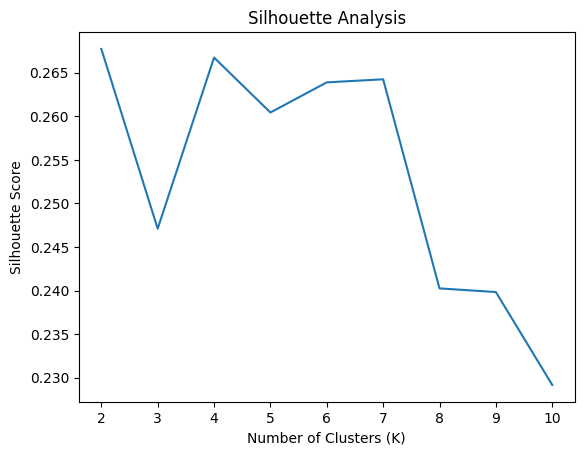

In [67]:
# K-means

scaler3 = MinMaxScaler()
scaler3.fit(data_normal)
scaled_data_normal_all = scaler3.transform(data_normal.copy())

# Selecting number of clusters

_min_clusters, _max_clusters = 2,11
silhouette_scores = []
for k in range(_min_clusters, _max_clusters):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(scaled_data_normal_all)
    score = silhouette_score(scaled_data_normal_all, kmeans.labels_)
    silhouette_scores.append(score)
plt.plot(range(_min_clusters, _max_clusters), silhouette_scores)
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Analysis')
plt.show()

n_clusters = int(np.arange(_min_clusters, _max_clusters)[np.where(silhouette_scores==max(silhouette_scores))][0])

In [68]:
assert n_clusters == 2

kmeans3 = KMeans(n_clusters=2)
kmeans3.fit(data_normal)
centroids_normal = kmeans3.cluster_centers_

clustering_results['K-Means (normal)'] = kmeans3.labels_

D:\conda\envs\tf_gpu2\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
D:\conda\envs\tf_gpu2\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


In [69]:
from sklearn.cluster import AffinityPropagation
# Affinity propagation

affprop = AffinityPropagation()
affprop.fit(data_normal)
exemplars_normal = affprop.cluster_centers_
clustering_results['Affinity propagation (normal)'] = affprop.labels_

In [70]:
from sklearn.cluster import MeanShift, estimate_bandwidth

bandwidth = estimate_bandwidth(data_normal, quantile=0.2, n_samples=56)
mean_shift = MeanShift(bandwidth=bandwidth)
mean_shift.fit(data_normal)
ms_centers_normal = mean_shift.cluster_centers_

clustering_results['Mean-shift (normal)'] = mean_shift.labels_

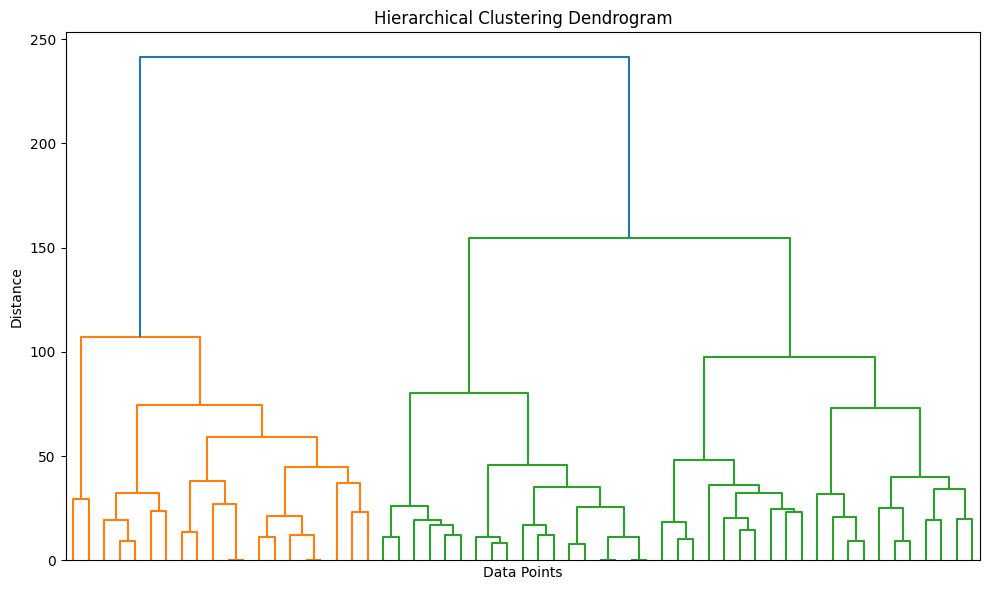

In [71]:
from scipy.cluster.hierarchy import dendrogram, linkage

plt.figure(figsize=(10, 6))
Z = linkage(data_normal, method='ward')
dendrogram(Z, no_labels=True)
plt.xlabel('Data Points')
plt.ylabel('Distance')
plt.title('Hierarchical Clustering Dendrogram')
plt.tight_layout()
plt.show()

```n_clusters = 4```

In [74]:
from sklearn.cluster import AgglomerativeClustering

clustering = AgglomerativeClustering(n_clusters=4)
labels = clustering.fit_predict(data_normal)
clustering_results['Agglomerative clustering (normal)'] = labels

D:\conda\envs\tf_gpu2\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
D:\conda\envs\tf_gpu2\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
D:\conda\envs\tf_gpu2\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
D:\conda\envs\tf_gpu2\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, 

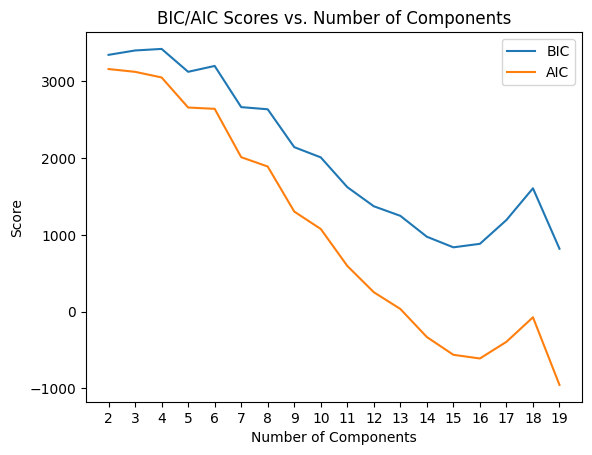

In [75]:
from sklearn.mixture import GaussianMixture

n_components_range = range(2, 20)

bic_scores = []
aic_scores = []
for n_components in n_components_range:
    gmm = GaussianMixture(n_components=n_components)
    gmm.fit(data_normal)
    bic_scores.append(gmm.bic(data_normal))
    aic_scores.append(gmm.aic(data_normal))

plt.plot(n_components_range, bic_scores, label='BIC')
plt.plot(n_components_range, aic_scores, label='AIC')
plt.xlabel('Number of Components')
plt.ylabel('Score')
plt.xticks(n_components_range)
plt.title('BIC/AIC Scores vs. Number of Components')
plt.legend()
plt.show()

```n_components = 16``` which is not good for dataset with 56 samples

In [97]:
new_data.shape

(59, 2)

In [98]:
clustering_results['x'] = new_data[:,0]
clustering_results['y'] = new_data[:,1]

<Axes: xlabel='x', ylabel='y'>

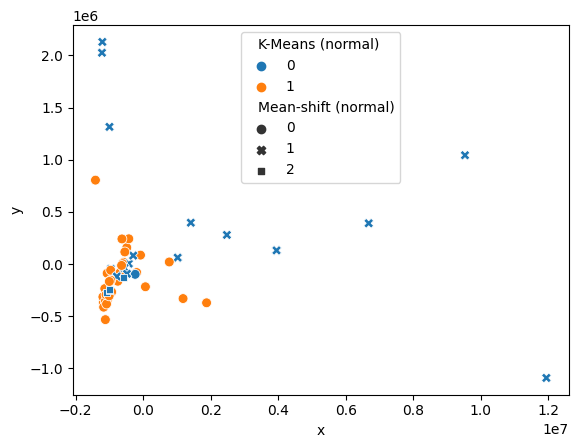

In [101]:
sns.scatterplot(data=pd.DataFrame(clustering_results), x='x', y='y', hue='K-Means (normal)', style='Mean-shift (normal)', s=50)

<Axes: xlabel='x', ylabel='y'>

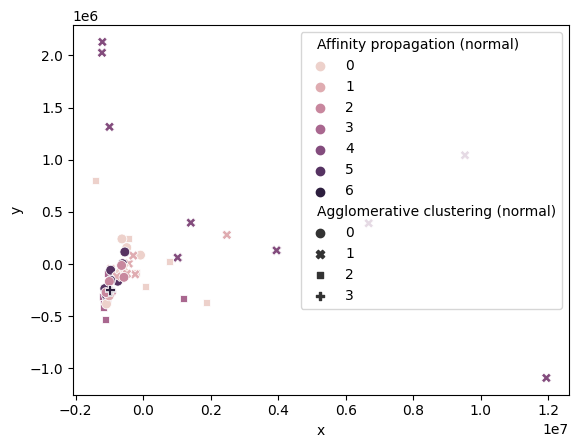

In [102]:
sns.scatterplot(data=pd.DataFrame(clustering_results), x='x', y='y', hue='Affinity propagation (normal)', style='Agglomerative clustering (normal)', s=50)

In [76]:
pd.DataFrame(clustering_results)

City  K-Means (normal)   
0                Greenpoint/Williamsburg                 0  \
1           Fort Greene/Brooklyn Heights                 0   
2                     Bedford Stuyvesant                 1   
3                               Bushwick                 1   
4            East New York/Starrett City                 1   
5             Park Slope/Carroll Gardens                 0   
6                            Sunset Park                 1   
7         Crown Heights/Prospect Heights                 1   
8   South Crown Heights/Lefferts Gardens                 1   
9                Bay Ridge/Dyker Heights                 0   
10                           Bensonhurst                 1   
11                          Borough Park                 0   
12                          Coney Island                 0   
13                      Flatbush/Midwood                 0   
14                        Sheepshead Bay                 0   
15                           Brownsville                 1   
16                         East Flatbush                 1   
17                    Flatlands/Canarsie                 1   
18                    Mott Haven/Melrose                 1   
19                  Hunts Point/Longwood                 1   
20                    Morrisania/Crotona                 1   
21                  Highbridge/Concourse                 1   
22            Fordham/University Heights                 1   
23                  Belmont/East Tremont                 1   
24           Kingsbridge Heights/Bedford                 1   
25                   Riverdale/Fieldston                 1   
26                 Parkchester/Soundview                 1   
27                Throgs Neck/Co-op City                 1   
28                 Morris Park/Bronxdale                 1   
29             Williamsbridge/Baychester                 1   
30                    Financial District                 0   
31                Greenwich Village/Soho                 0   
32             Lower East Side/Chinatown                 1   
33                       Clinton/Chelsea                 0   
34                               Midtown                 0   
35            Stuyvesant Town/Turtle Bay                 0   
36                       Upper West Side                 0   
37                       Upper East Side                 0   
38          Morningside Heights/Hamilton                 1   
39                        Central Harlem                 1   
40                           East Harlem                 1   
41             Washington Heights/Inwood                 1   
42                               Astoria                 0   
43                    Woodside/Sunnyside                 1   
44                       Jackson Heights                 1   
45                       Elmhurst/Corona                 1   
46                     Ridgewood/Maspeth                 0   
47                Rego Park/Forest Hills                 0   
48                   Flushing/Whitestone                 1   
49               Hillcrest/Fresh Meadows                 1   
50                 Kew Gardens/Woodhaven                 1   
51         South Ozone Park/Howard Beach                 1   
52                   Bayside/Little Neck                 0   
53                        Jamaica/Hollis                 1   
54                        Queens Village                 1   
55                Rockaway/Broad Channel                 1   
56                  St. George/Stapleton                 0   
57               South Beach/Willowbrook                 0   
58               Tottenville/Great Kills                 0   

    Affinity propagation (normal)  Mean-shift (normal)   
0                               4                    1  \
1                               1                    1   
2                               0                    0   
3                               0                    0   
4                        

## Nonnormal data

D:\conda\envs\tf_gpu2\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
D:\conda\envs\tf_gpu2\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
D:\conda\envs\tf_gpu2\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
D:\conda\envs\tf_gpu2\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable 

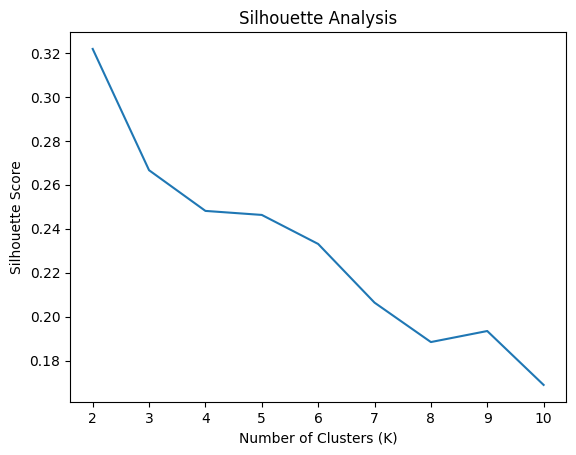

In [77]:
# K-means

scaler3 = MinMaxScaler()
scaler3.fit(data_nonnormal[data_nonnormal.columns[1:]])
scaled_data_nonnormal_all = scaler3.transform(data_nonnormal[data_nonnormal.columns[1:]].copy())

# Selecting number of clusters

_min_clusters, _max_clusters = 2,11
silhouette_scores = []
for k in range(_min_clusters, _max_clusters):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(scaled_data_nonnormal_all)
    score = silhouette_score(scaled_data_nonnormal_all, kmeans.labels_)
    silhouette_scores.append(score)
plt.plot(range(_min_clusters, _max_clusters), silhouette_scores)
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Analysis')
plt.show()

n_clusters = int(np.arange(_min_clusters, _max_clusters)[np.where(silhouette_scores==max(silhouette_scores))][0])

In [78]:
assert n_clusters == 2

kmeans3 = KMeans(n_clusters=2)
kmeans3.fit(data_nonnormal[data_nonnormal.columns[1:]])
centroids_nonnormal = kmeans3.cluster_centers_

clustering_results['K-Means (nonnormal)'] = kmeans3.labels_

D:\conda\envs\tf_gpu2\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
D:\conda\envs\tf_gpu2\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


In [79]:
print(centroids_normal, centroids_nonnormal)

[[48.57272727 31.08181818 39.85       24.41363636 66.52272727 22.50909091
  59.16363636 15.72272727]
 [48.27837838 38.97297297 26.82432432 32.87297297 62.01351351 25.8972973
  16.15405405 13.16756757]] [[4.85982143e+01 7.02053571e+01 8.67678571e+00 1.41107143e+01
  4.79285714e+00 2.04821429e+00 2.00571429e+01 8.49107143e+00
  4.07500000e+01 6.53214286e+00 6.21099286e+04 5.83928571e+00
  3.21575000e+02 4.25089286e+01 6.15757143e+04 9.53869643e+04
  5.02555357e+04 1.49000000e+03 1.44589286e+03 2.15982143e+03
  1.63303571e+03 1.27160714e+03 9.56937679e+05 4.43720357e+05
  2.79249643e+05 6.28804643e+05 3.02464286e+01 1.85178571e+01
  1.23500000e+01 1.83178571e+02 7.19285714e+01 1.03857143e+02
  1.36642857e+01 3.09071429e+01 2.25785714e+01 3.00607143e+01
  1.55326750e+05 1.95142857e+01 1.39196429e+01 4.26071429e+01
  1.94017857e+01 2.05660714e+01 2.55660714e+01 5.91196429e+01]
 [4.44666667e+01 8.56666667e+01 4.26666667e+00 1.77635684e-15
  3.00000000e-01 4.33333333e-01 1.88666667e+01 2.0000

In [80]:
affprop = AffinityPropagation()
affprop.fit(data_nonnormal[data_nonnormal.columns[1:]])
exemplars_nonnormal = affprop.cluster_centers_
clustering_results['Affinity propagation (nonnormal)'] = affprop.labels_

In [81]:
exemplars_normal, exemplars_nonnormal

(array([[41.5, 41.1, 17.3, 26.4, 64.9, 25.8, 25.5, 15.3],
        [50.8, 38.8, 42. , 28.4, 63.8, 22.5, 50.9, 17.1],
        [53.2, 40. , 56.9, 34.7, 62.5, 23.3, 22.4, 15.3],
        [53.4, 32.3,  6.8, 41.6, 58.2, 25. ,  3.8, 10.3],
        [37.8, 22.9, 30.7, 16.1, 72.1, 19.4, 72.2, 14.3],
        [39.6, 53.6, 45.9, 32.6, 66.3, 27.7, 17.7, 12.9],
        [65.5, 30.1, 71.1, 37.9, 59.7, 22.2, 64.1, 16. ]]),
 array([[4.670000e+01, 8.440000e+01, 6.800000e+00, 0.000000e+00,
         0.000000e+00, 1.700000e+00, 2.770000e+01, 1.000000e+00,
         1.570000e+01, 8.200000e+00, 6.983400e+04, 7.700000e+00,
         4.554000e+02, 3.460000e+01, 7.807000e+04, 8.303000e+04,
         7.720000e+04, 1.540000e+03, 2.000000e+03, 2.980000e+03,
         2.300000e+03, 1.700000e+03, 2.420290e+06, 7.348400e+05,
         3.838500e+05, 9.477400e+05, 2.660000e+01, 3.560000e+01,
         5.600000e+00, 1.090000e+02, 4.500000e+01, 4.700000e+01,
         7.000000e+00, 2.160000e+01, 3.600000e+00, 6.450000e+01,
       

In [82]:
from sklearn.cluster import MeanShift, estimate_bandwidth

bandwidth = estimate_bandwidth(data_nonnormal[data_nonnormal.columns[1:]], quantile=0.2, n_samples=56)
mean_shift = MeanShift(bandwidth=bandwidth)
mean_shift.fit(data_nonnormal[data_nonnormal.columns[1:]])
ms_centers_normal = mean_shift.cluster_centers_

clustering_results['Mean-shift (nonnormal)'] = mean_shift.labels_

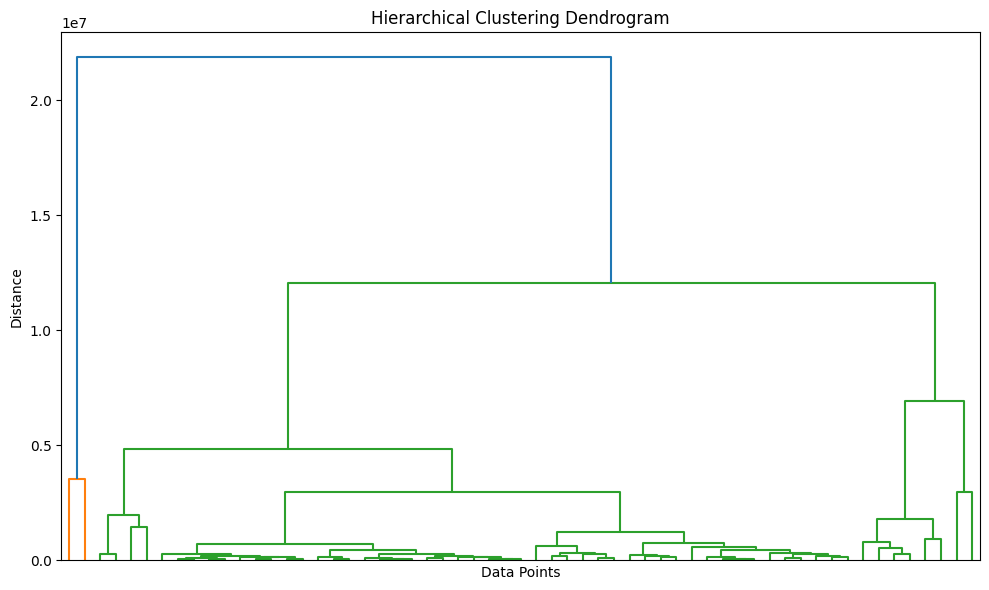

In [83]:
from scipy.cluster.hierarchy import dendrogram, linkage

plt.figure(figsize=(10, 6))
Z = linkage(data_nonnormal[data_nonnormal.columns[1:]], method='ward')
dendrogram(Z, no_labels=True)
plt.xlabel('Data Points')
plt.ylabel('Distance')
plt.title('Hierarchical Clustering Dendrogram')
plt.tight_layout()
plt.show()

In [84]:
clustering = AgglomerativeClustering(n_clusters=6)
labels = clustering.fit_predict(data_nonnormal[data_nonnormal.columns[1:]])
clustering_results['Agglomerative clustering (nonnormal)'] = labels

In [85]:
pd.DataFrame(clustering_results).sort_values(by='K-Means (normal)')

City  K-Means (normal)   
0                Greenpoint/Williamsburg                 0  \
56                  St. George/Stapleton                 0   
52                   Bayside/Little Neck                 0   
47                Rego Park/Forest Hills                 0   
46                     Ridgewood/Maspeth                 0   
42                               Astoria                 0   
37                       Upper East Side                 0   
36                       Upper West Side                 0   
35            Stuyvesant Town/Turtle Bay                 0   
34                               Midtown                 0   
33                       Clinton/Chelsea                 0   
31                Greenwich Village/Soho                 0   
30                    Financial District                 0   
57               South Beach/Willowbrook                 0   
58               Tottenville/Great Kills                 0   
1           Fort Greene/Brooklyn Heights                 0   
14                        Sheepshead Bay                 0   
9                Bay Ridge/Dyker Heights                 0   
5             Park Slope/Carroll Gardens                 0   
11                          Borough Park                 0   
12                          Coney Island                 0   
13                      Flatbush/Midwood                 0   
15                           Brownsville                 1   
41             Washington Heights/Inwood                 1   
43                    Woodside/Sunnyside                 1   
44                       Jackson Heights                 1   
45                       Elmhurst/Corona                 1   
4            East New York/Starrett City                 1   
3                               Bushwick                 1   
48                   Flushing/Whitestone                 1   
49               Hillcrest/Fresh Meadows                 1   
50                 Kew Gardens/Woodhaven                 1   
51         South Ozone Park/Howard Beach                 1   
2                     Bedford Stuyvesant                 1   
53                        Jamaica/Hollis                 1   
54                        Queens Village                 1   
55                Rockaway/Broad Channel                 1   
40                           East Harlem                 1   
39                        Central Harlem                 1   
7         Crown Heights/Prospect Heights                 1   
6                            Sunset Park                 1   
16                         East Flatbush                 1   
17                    Flatlands/Canarsie                 1   
18                    Mott Haven/Melrose                 1   
19                  Hunts Point/Longwood                 1   
20                    Morrisania/Crotona                 1   
21                  Highbridge/Concourse                 1   
22            Fordham/University Heights                 1   
38          Morningside Heights/Hamilton                 1   
23                  Belmont/East Tremont                 1   
25                   Riverdale/Fieldston                 1   
26                 Parkchester/Soundview                 1   
27                Throgs Neck/Co-op City                 1   
28                 Morris Park/Bronxdale                 1   
32             Lower East Side/Chinatown                 1   
10                           Bensonhurst                 1   
8   South Crown Heights/Lefferts Gardens                 1   
24           Kingsbridge Heights/Bedford                 1   
29             Williamsbridge/Baychester                 1   

    Affinity propagation (normal)  Mean-shift (normal)   
0                               4                    1  \
56                              2                    2   
52                              2                    2   
47                              1                    1   
46                       

<Axes: xlabel='x', ylabel='y'>

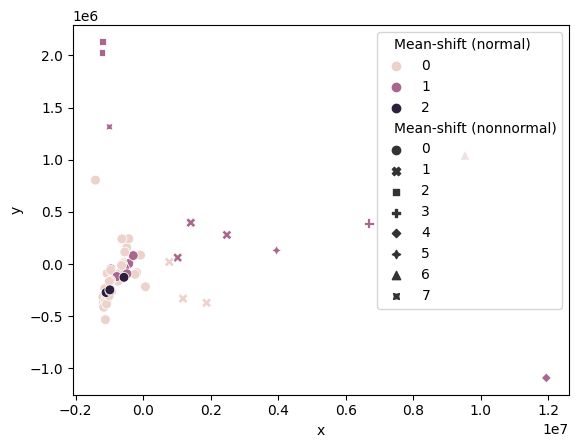

In [104]:
sns.scatterplot(data=pd.DataFrame(clustering_results), x='x', y='y', hue='Mean-shift (normal)', style='Mean-shift (nonnormal)', s=50)

Nonnormal

+ Data can be divided into 2-3 groups in general, each classification method divides the data into approximately this number of groups (some methods divide these groups more)

+ For some reason, the following cities are strongly out of the clustering: Clinton/Chelsea, Upper West Side and Upper East Side, Morningside Heights/Hamilton

In general

+ Clustering very depent from used dataset and clustering method
+ K-means and Mean-shift performs on data very close each one 
+ Affinity propagation has dividing close to Agglomerative clustering's results